#### Adicionando o caminho do projeto ao path

In [53]:
import os
os.chdir('/Users/edithvidal/Documents/Github/data_science_analysis/')

#### Instalando sklearn

In [54]:
%pip install scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


#### Importando as bibliotecas necessárias para a análise

In [55]:
import pandas as pd  # type: ignore
import numpy as np  # type: ignore
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from scipy.stats import chi2_contingency

#### Lendo os dados da base tratada de 2018 a 2024

In [56]:
df_accidents = pd.read_csv(
    "wrangling/datatran2018_2024_v1.csv",
    parse_dates=["data_inversa", "mes_ano"]
)
df_accidents.info()
df_accidents.reset_index(drop=True, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429769 entries, 0 to 429768
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      429769 non-null  float64       
 1   data_inversa            429769 non-null  datetime64[ns]
 2   tipo_data               429769 non-null  object        
 3   mes_ano                 429769 non-null  datetime64[ns]
 4   dia_semana              429769 non-null  object        
 5   horario                 429769 non-null  object        
 6   fase_dia                429769 non-null  object        
 7   condicao_metereologica  429769 non-null  object        
 8   uf                      429769 non-null  object        
 9   br                      429769 non-null  float64       
 10  km                      429769 non-null  object        
 11  uso_solo                429769 non-null  object        
 12  tipo_pista              429769

#### Criando funções auxiliares para gerar os gráficos

In [57]:
def draw_histplot(
    df,
    title="Histograma",
    x_label="",
    y_label="Frequência",
    width=8,
    height=5,
    bins=20,
):
    plt.figure(figsize=(width, height))
    sns.histplot(df, bins=bins)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()


def draw_boxplot(
    df,
    title="Gráfico de caixas",
    x_label="",
    y_label="Frequência",
    width=8,
    height=5,
    multipleLocator=1,
):
    plt.figure(figsize=(width, height))
    sns.boxplot(df, y=df.columns[1])
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.gca().yaxis.set_major_locator(
        mticker.MultipleLocator(multipleLocator))
    plt.gca().yaxis.set_major_formatter(
        mticker.StrMethodFormatter("{x:.0f}"))
    plt.show()


def draw_barplot(enable_lineplot, set_yscale, df, x, y, title):
    plt.figure(figsize=(25, 6))
    if set_yscale:
        ax = sns.barplot(
            data=df,
            x=x,
            y=y,
            color="skyblue"
        )
        ax.set_yscale("log")
    else:
        sns.barplot(
            data=df,
            x=x,
            y=y,
            color="skyblue"
        )

    if enable_lineplot:
        sns.lineplot(
            data=df,
            x=x,
            y=y,
            marker="o",
            color="red",
            linewidth=1
        )
        plt.grid(axis="y", linestyle="--", alpha=0.5)

    plt.title(title, fontsize=16)
    plt.ylabel("Frequência de acidentes")
    plt.xticks(rotation=45, ha="right")
    plt.margins(x=0)
    plt.tick_params(axis='x', labelsize=13)
    plt.tick_params(axis='y', labelsize=13)
    plt.show()


def draw_pie(df, labels, title=""):
    colors = sns.color_palette("pastel")[:len(labels)]

    plt.figure(figsize=(8, 8))
    plt.pie(
        x=df,
        labels=labels,
        autopct="%1.1f%%",
        colors=colors
    )
    plt.title(title)
    plt.show()

#### Criando funções auxiliares para as análises

In [58]:
def get_weekdays():
    return [
        "Domingo",
        "Segunda-feira",
        "Terça-feira",
        "Quarta-feira",
        "Quinta-feira",
        "Sexta-feira",
        "Sábado"
    ]


def get_months():
    months = {
        1: "Janeiro",
        2: "Fevereiro",
        3: "Março",
        4: "Abril",
        5: "Maio",
        6: "Junho",
        7: "Julho",
        8: "Agosto",
        9: "Setembro",
        10: "Outubro",
        11: "Novembro",
        12: "Dezembro",
    }
    months_sorted = [
        months[1],
        months[2],
        months[3],
        months[4],
        months[5],
        months[6],
        months[7],
        months[8],
        months[9],
        months[10],
        months[11],
        months[12]
    ]

    return months, months_sorted


def get_date_range():
    return pd.date_range(
        start=df_accidents['mes_ano'].min(),
        end=df_accidents['mes_ano'].max(),
        freq='MS'
    )


def sort_by_index(df):
    return df.value_counts().sort_index()


def sort_by_values(df, ascending=False):
    return df.value_counts().sort_values(ascending=ascending)


def group_by_month_year():
    df = sort_by_index(df_accidents["mes_ano"])
    df.index = df.index.strftime("%Y-%m")
    df = df.reindex(
        get_date_range().strftime("%Y-%m"), fill_value=0)

    return df


def group_by_year():
    return sort_by_index(df_accidents["mes_ano"].dt.year)


def group_by_month():
    months, months_sorted = get_months()

    df = sort_by_index(df_accidents["mes_ano"].dt.month)
    df.index = df.index.map(months)
    df.index = pd.Categorical(
        df.index, categories=months_sorted, ordered=True)

    return df


def group_by_hour(df):
    return df[df["horario"].notna()]["horario"]


def to_datetime(df):
    return pd.to_datetime(df, format="%H:%M:%S").dt.hour


def melt(table, id_vars, var_name, value_name):
    data = table.melt(
        id_vars=id_vars, var_name=var_name, value_name=value_name)
    return data.to_dict(orient="records")

## Análise univariada

#### Análise da distribuição dos acidentes por mês e ano

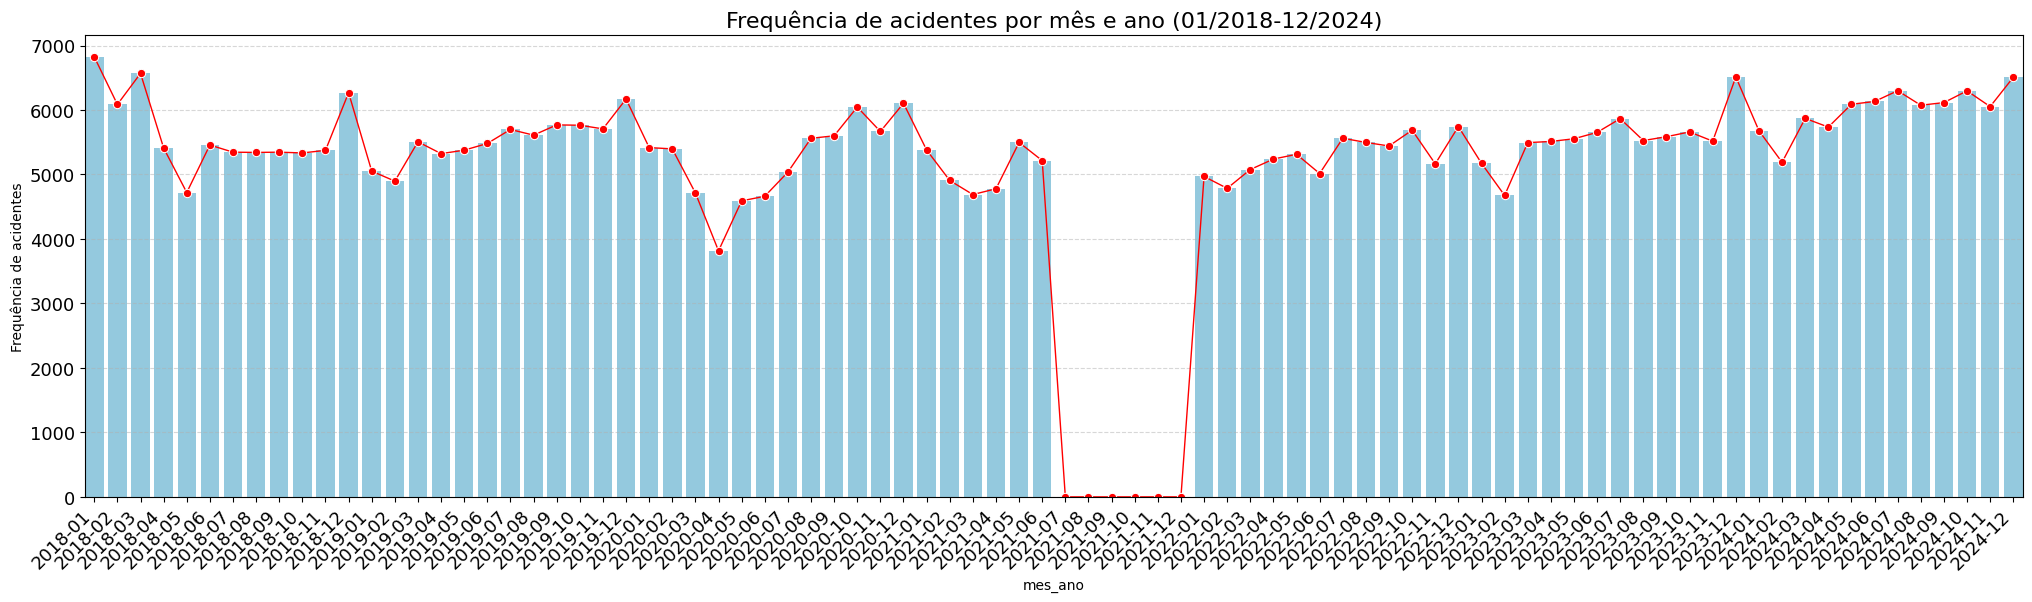

In [59]:
df_month_year = group_by_month_year()
df = pd.DataFrame({
    "mes_ano": df_month_year.index, "frequencia": df_month_year.values
})
draw_barplot(
    enable_lineplot=True,
    set_yscale=False,
    df=df,
    x="mes_ano",
    y="frequencia",
    title="Frequência de acidentes por mês e ano (01/2018-12/2024)"
)

#### Análise da distribuição dos acidentes por ano

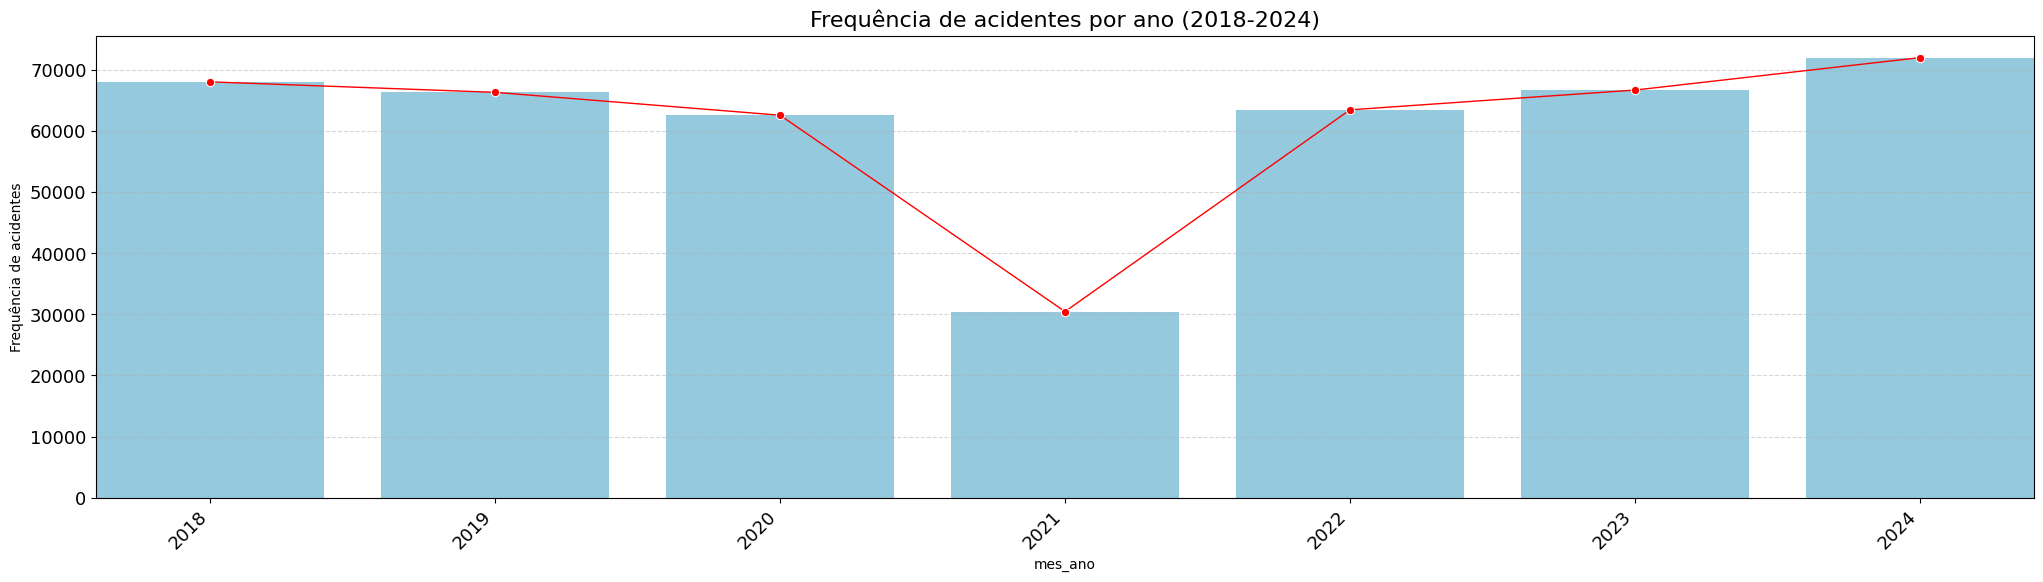

In [60]:
df_year = group_by_year()
df = pd.DataFrame({
    "mes_ano": df_year.index, "frequencia": df_year.values
})
draw_barplot(
    enable_lineplot=True,
    set_yscale=False,
    df=df,
    x=df["mes_ano"].astype(str),
    y="frequencia",
    title="Frequência de acidentes por ano (2018-2024)"
)

#### Análise da distribuição dos acidentes por mês

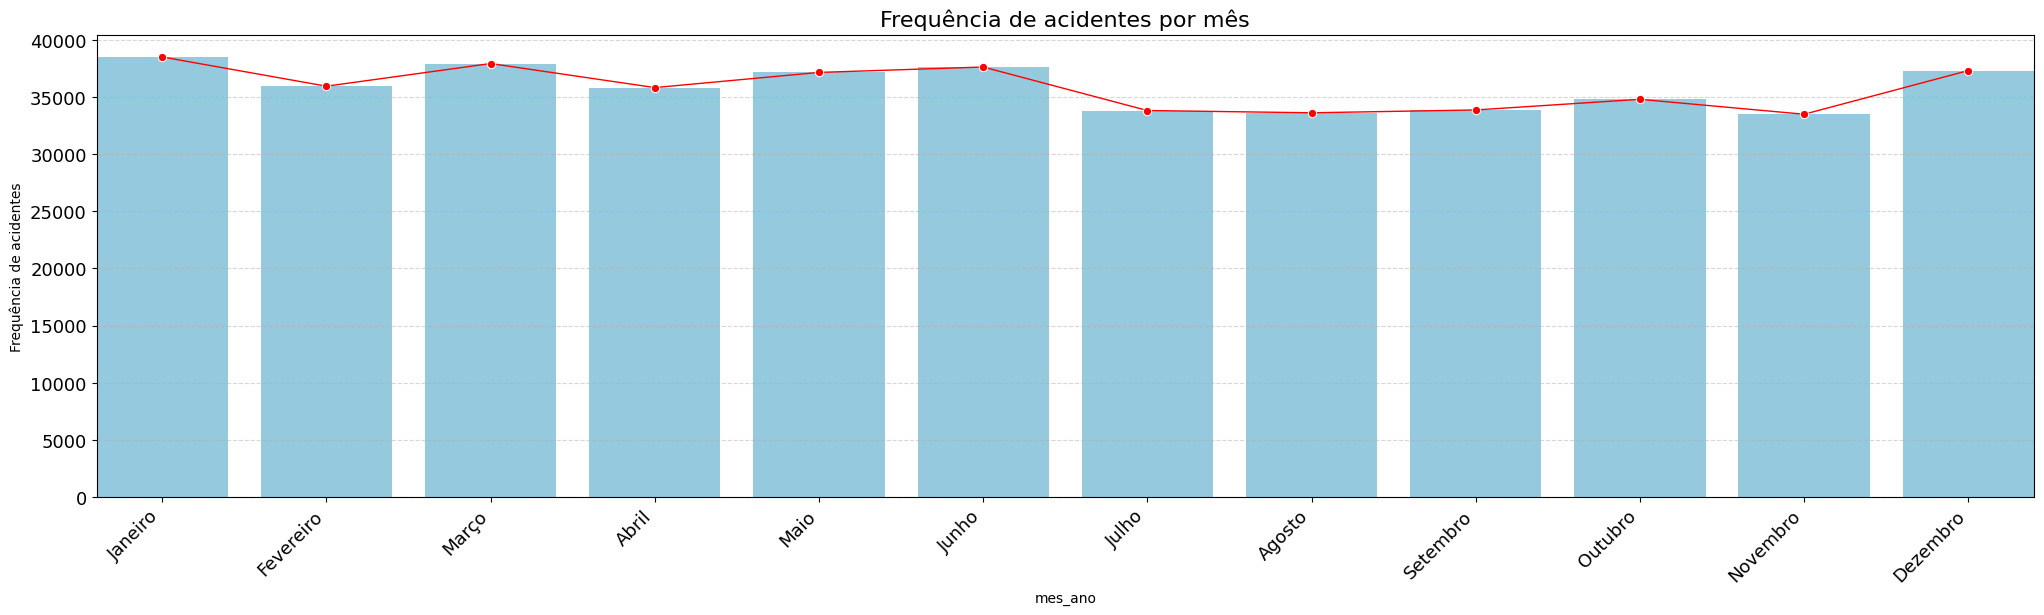

In [61]:
df_month = group_by_month()
df = pd.DataFrame({
    "mes_ano": df_month.index, "frequencia": df_month.values
})
draw_barplot(
    enable_lineplot=True,
    set_yscale=False,
    df=df,
    x="mes_ano",
    y="frequencia",
    title="Frequência de acidentes por mês"
)

#### Analisando os dados do ano de 2021, foi possível perceber que os meses de julho a dezembro não foram populados. Para não influenciar negativamente nas análises, preencherei esses dados considerando a média ou mediana dos demais anos

In [ ]:
end_of_month = dict({7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31})


def fill_occurrences_dict(df, day, month, year):
    occurrences_dict = {}
    current_date = f'{year}-{month:02d}-{day:02d}'
    count = df_accidents[df == current_date].shape[0]
    occurrences_dict[current_date] = count
    return occurrences_dict


def create_lines_by_mean(day, month, mean):
    value = [pd.to_datetime(f'2021-{month:02d}-{day:02d}')] * mean
    return pd.DataFrame({
        'data_inversa': value, 'mes_ano': value,
    })


def fill_na(df):
    for col in df_accidents.columns:
        if col not in ('data_inversa', 'mes_ano'):
            df[col] = np.nan
    return df


for month in end_of_month:
    for day in range(1, end_of_month[month] + 1):
        for year in [2018, 2019, 2020, 2022, 2023, 2024]:
            occurrences = fill_occurrences_dict(
                df_accidents["data_inversa"], day, month, year)

        mean = int(np.mean(list(occurrences.values())))

        df = create_lines_by_mean(day, month, mean)
        df = fill_na(df)

        df_accidents = pd.concat(
            [df_accidents, df], ignore_index=True)

df_accidents["mes_ano"] = df_accidents["data_inversa"].dt.to_period("M")
df_accidents.drop(columns=["data_inversa"], inplace=True)
df_accidents.to_csv(
    "analysis/datatran2018_2024_v2.csv", index=False)

#### Lendo a nova base de dados após o tratamento do ano de 2021

In [ ]:
df_accidents = pd.read_csv(
    "analysis/datatran2018_2024_v2.csv",
    parse_dates=["mes_ano"]
)
df_accidents.reset_index(drop=True, inplace=True)

/var/folders/z1/3syxl8gd5ks431s8c9n9mrs00000gn/T/ipykernel_12238/2782063256.py:1: DtypeWarning: Columns (1,3,4,5,6,7,9,10,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_accidents = pd.read_csv(


#### Análise da distribuição dos acidentes por mês e ano (após tratamento de 2021)

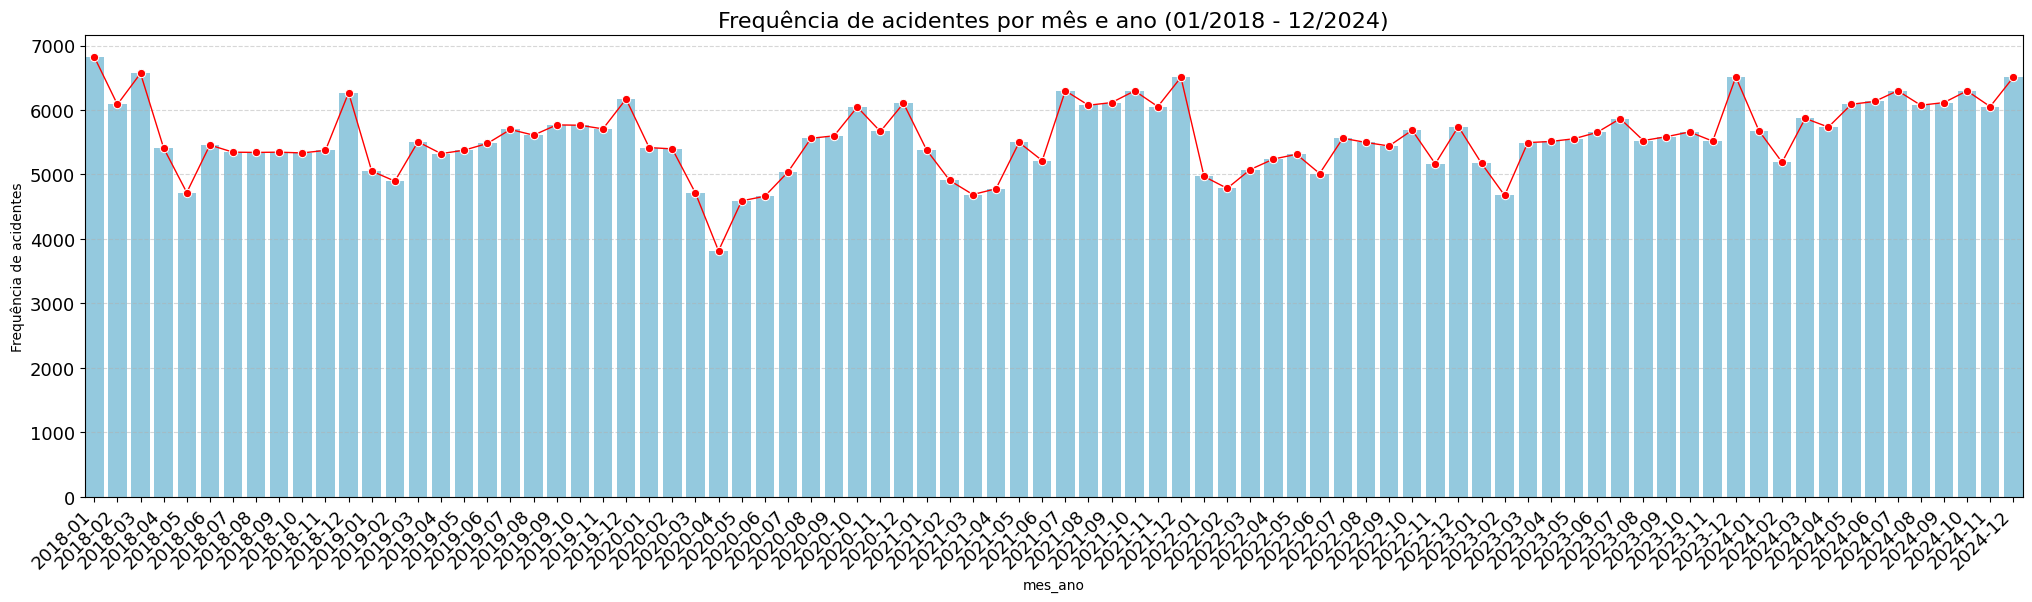

In [ ]:
df_month_year = group_by_month_year()
df = pd.DataFrame({
    "mes_ano": df_month_year.index, "frequencia": df_month_year.values
})
draw_barplot(
    enable_lineplot=True,
    set_yscale=False,
    df=df,
    x="mes_ano",
    y="frequencia",
    title="Frequência de acidentes por mês e ano (01/2018 - 12/2024)"
)

#### Análise da distribuição dos acidentes por ano (após tratamento de 2021)

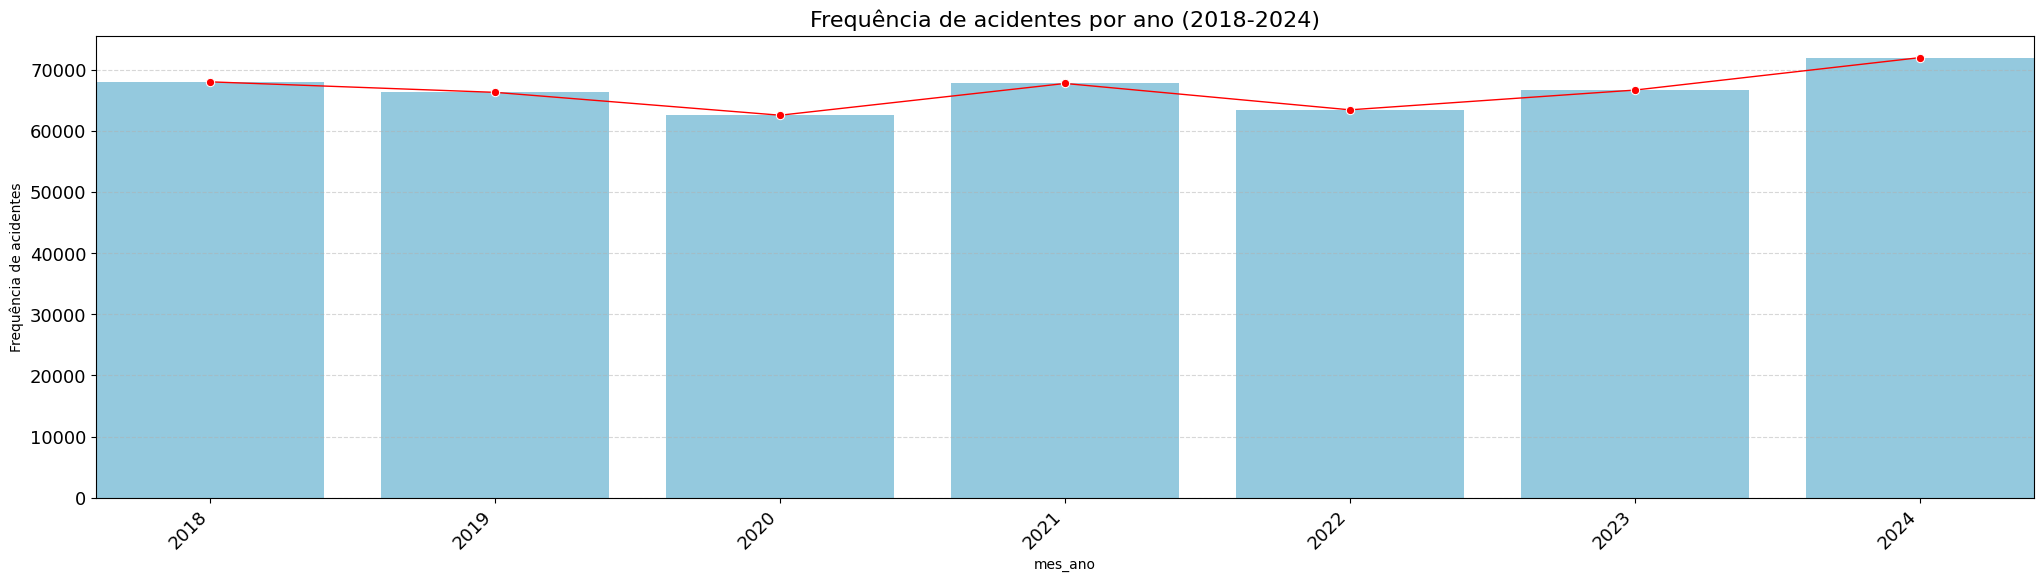

In [ ]:
df_year = group_by_year()
df = pd.DataFrame({
    "mes_ano": df_year.index, "frequencia": df_year.values
})
draw_barplot(
    enable_lineplot=True,
    set_yscale=False,
    df=df,
    x=df["mes_ano"].astype(str),
    y="frequencia",
    title="Frequência de acidentes por ano (2018-2024)"
)

#### Análise da distribuição dos acidentes por mês (após tratamento de 2021)

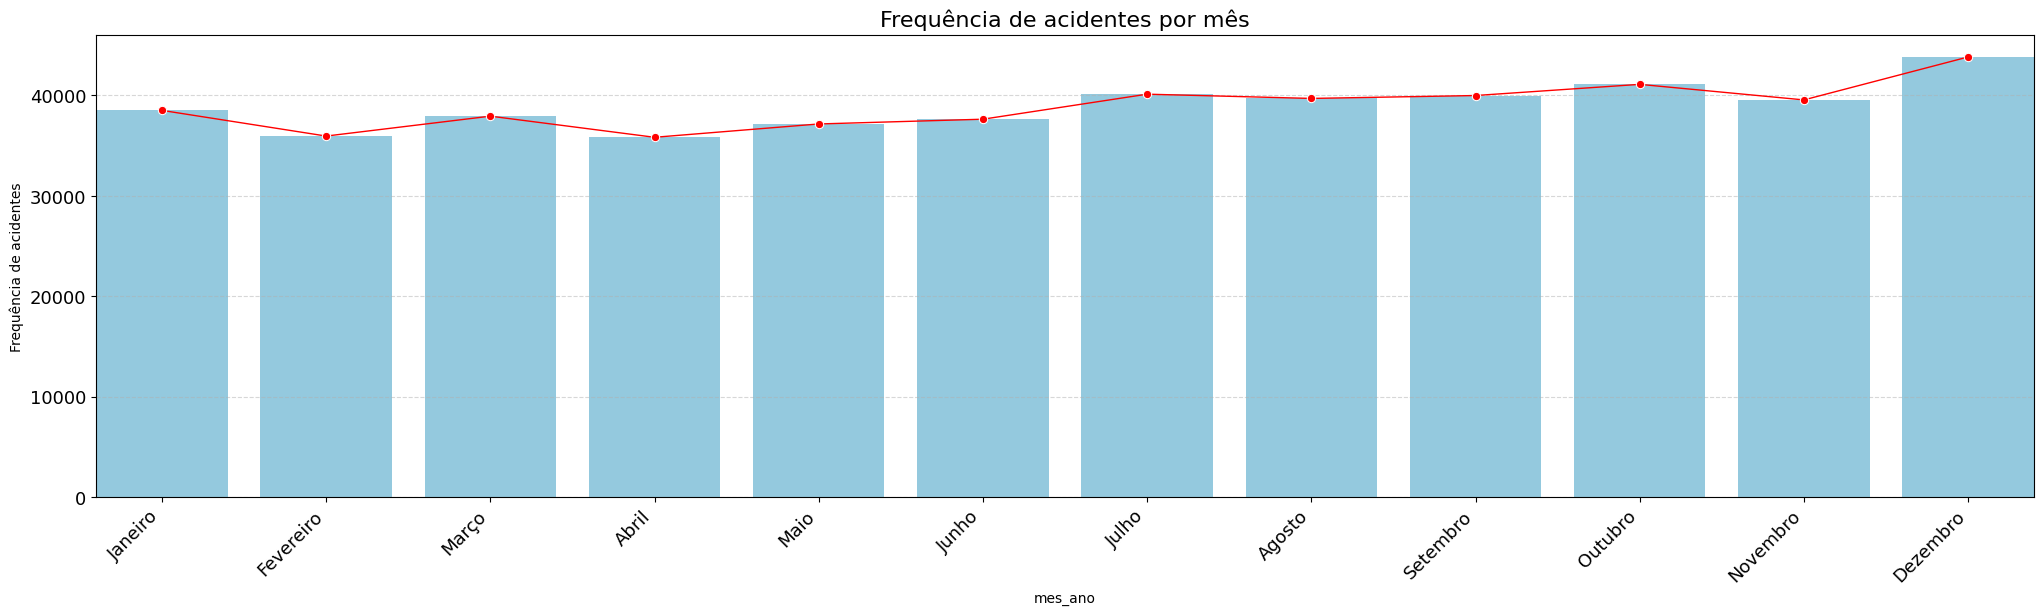

In [ ]:
df_month = group_by_month()
df = pd.DataFrame({
    "mes_ano": df_month.index, "frequencia": df_month.values
})
draw_barplot(
    enable_lineplot=True,
    set_yscale=False,
    df=df,
    x="mes_ano",
    y="frequencia",
    title="Frequência de acidentes por mês"
)

#### Análise univariada da coluna tipo_data, agrupando por Feriado ou Dia útil

                   tipo_data  frequencia
0                   Dia útil      415077
1   Confraternização mundial        1411
2                 Tiradentes        1262
3            Dia do trabalho        1254
4   Proclamação da República        1249
5    Nossa Senhora Aparecida        1237
6    Independência do Brasil        1224
7                     Páscoa        1211
8             Corpus Christi        1203
9                   Carnaval        1180
10                     Natal        1135
11         Sexta-feira Santa        1120
12                   Finados        1054
13  Dia da consciência negra         152


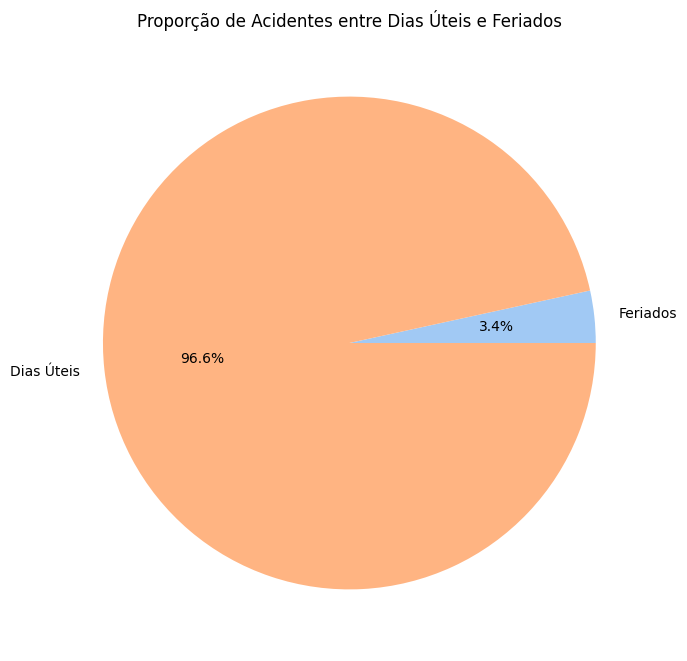

In [ ]:
series = sort_by_values(df=df_accidents["tipo_data"]).reset_index()
series.columns = ["tipo_data", "frequencia"]
print(series)

df = pd.DataFrame(
    {
        "categoria":
            ["Feriados", "Dias Úteis"],
        "frequencia": [
            series[series["tipo_data"] != "Dia útil"]["frequencia"].sum(),
            series[series["tipo_data"] == "Dia útil"]["frequencia"].sum()
                ]
    }
)

draw_pie(
    df=df["frequencia"],
    labels=df["categoria"],
    title="Proporção de Acidentes entre Dias Úteis e Feriados"
)

#### Analisando os feriados com mais ocorrências de acidentes

                   tipo_data  frequencia
0   Confraternização mundial        1411
1                 Tiradentes        1262
2            Dia do trabalho        1254
3   Proclamação da República        1249
4    Nossa Senhora Aparecida        1237
5    Independência do Brasil        1224
6                     Páscoa        1211
7             Corpus Christi        1203
8                   Carnaval        1180
9                      Natal        1135
10         Sexta-feira Santa        1120
11                   Finados        1054
12  Dia da consciência negra         152


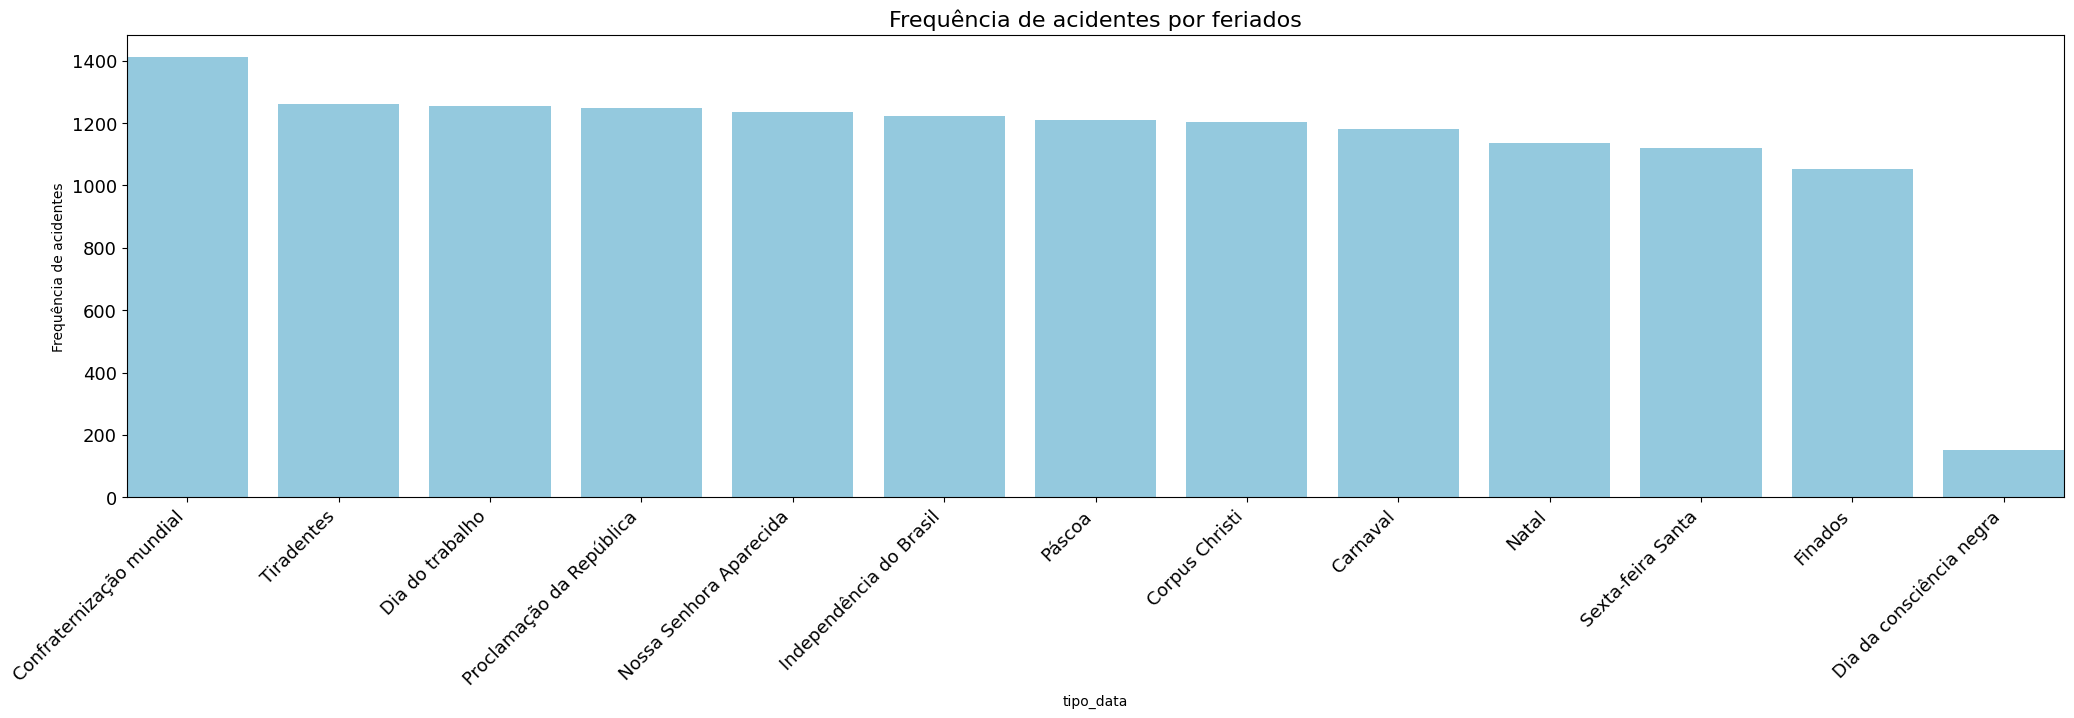

In [ ]:
df = df_accidents[df_accidents["tipo_data"] != "Dia útil"]
df = df["tipo_data"].value_counts().reset_index()
df.columns = ["tipo_data", "frequencia"]
print(df)

draw_barplot(
    enable_lineplot=False,
    set_yscale=False,
    df=df,
    x="tipo_data",
    y="frequencia",
    title="Frequência de acidentes por feriados"
)

#### Análise da distribuição de acidentes de acordo com o dia da semana

      dia_semana  frequencia
0        Domingo       70838
1         Sábado       70685
2    Sexta-feira       66212
3  Segunda-feira       58626
4   Quinta-feira       55866
5   Quarta-feira       54288
6    Terça-feira       53254


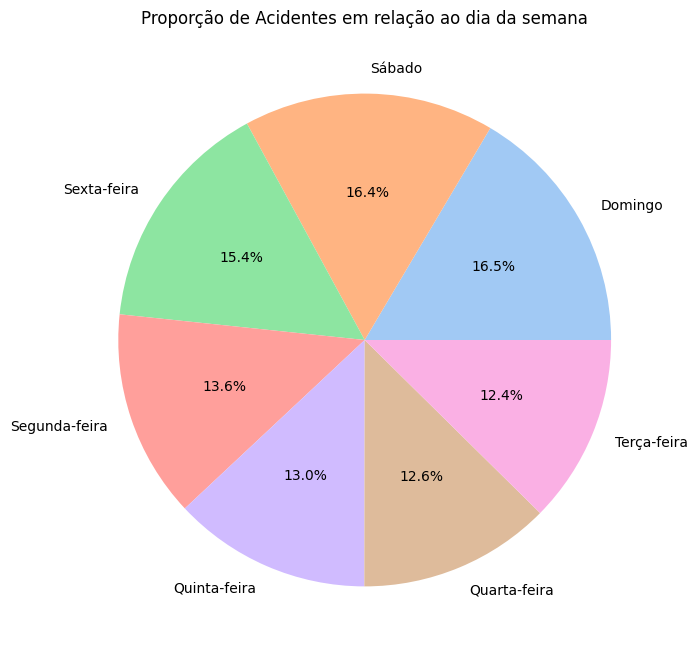

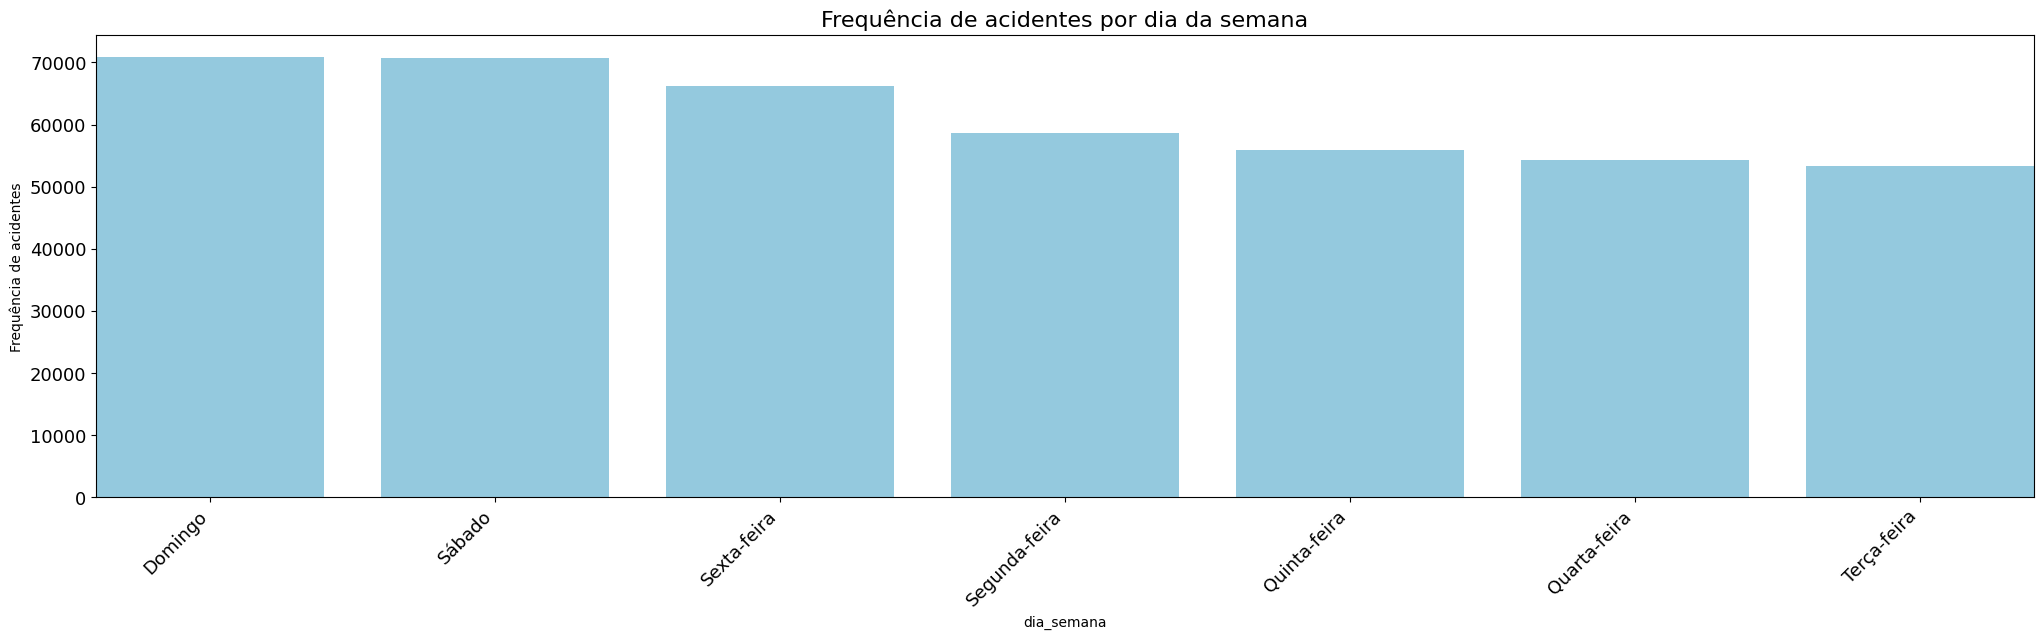

In [ ]:
df = df_accidents["dia_semana"].value_counts().reset_index()
df.columns = ["dia_semana", "frequencia"]
print(df)

draw_pie(
    df=df["frequencia"],
    labels=df["dia_semana"],
    title="Proporção de Acidentes em relação ao dia da semana"
)

draw_barplot(
    enable_lineplot=False,
    set_yscale=False,
    df=df,
    x="dia_semana",
    y="frequencia",
    title="Frequência de acidentes por dia da semana"
)

#### Análise da distribuição de acidentes por horário

   hora  frequencia
0    00        9023
1    01        7825
2    02        7071
3    03        7327
4    04        9083
5    05       12700
6    06       18592
7    07       25737
8    08       21384
9    09       18010
10   10       17982
11   11       18875
12   12       17790
13   13       19011
14   14       20817
15   15       22283
16   16       24366
17   17       28511
18   18       32805
19   19       27498
20   20       20159
21   21       16715
22   22       14494
23   23       11711


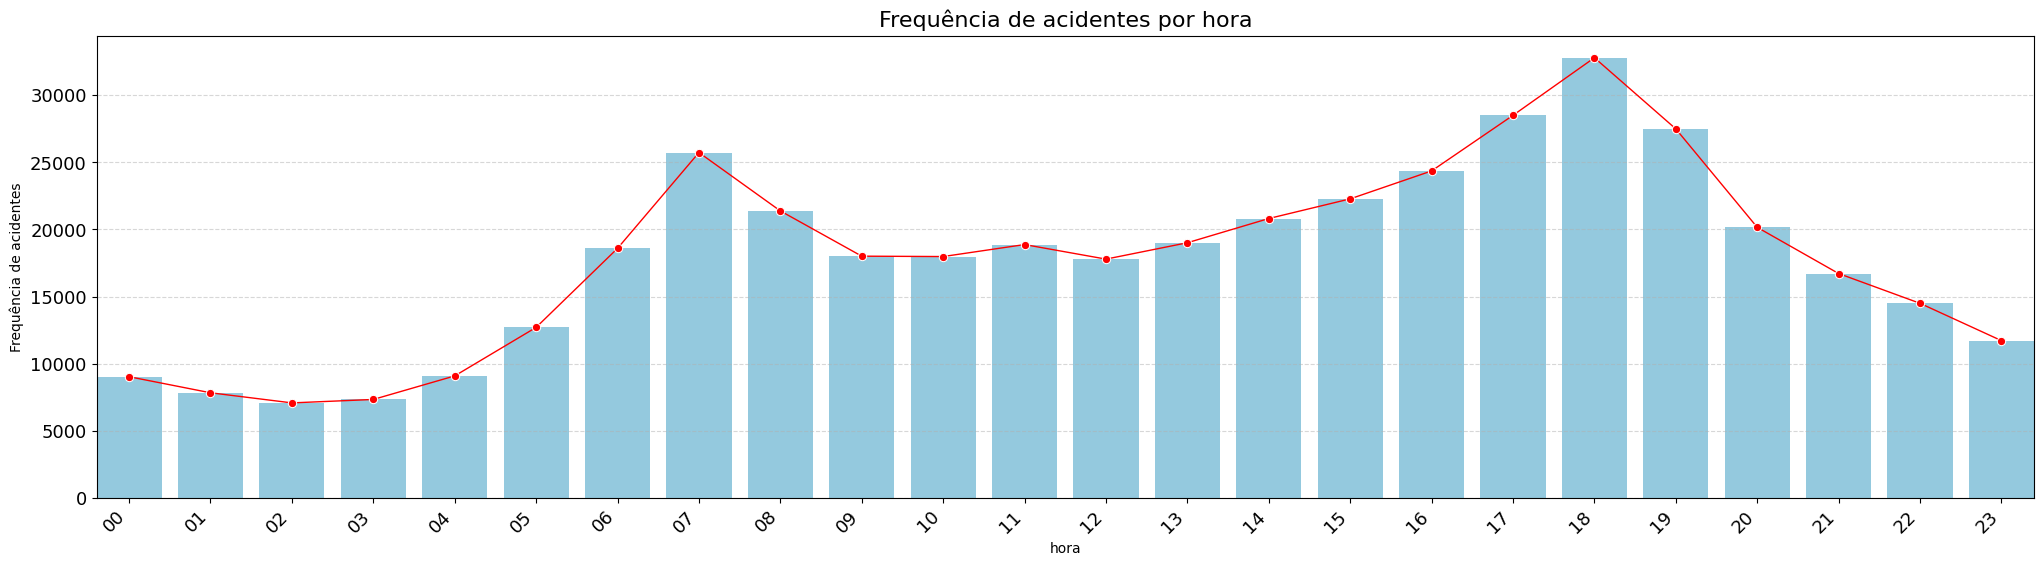

In [ ]:
df = group_by_hour(df_accidents)
df = to_datetime(df).astype(str).str.zfill(2)
df = sort_by_index(df).reset_index()
df.columns = ["hora", "frequencia"]
print(df)

draw_barplot(
    enable_lineplot=True,
    set_yscale=False,
    df=df,
    x="hora",
    y="frequencia",
    title="Frequência de acidentes por hora"
)

#### Análise da distribuição de acidentes por fase do dia

                 fase_dia  frequencia
0      12h às 18h (tarde)      132778
1      18h às 00h (noite)      123382
2      06h às 12h (manhã)      120580
3  00h às 06h (madrugada)       53029


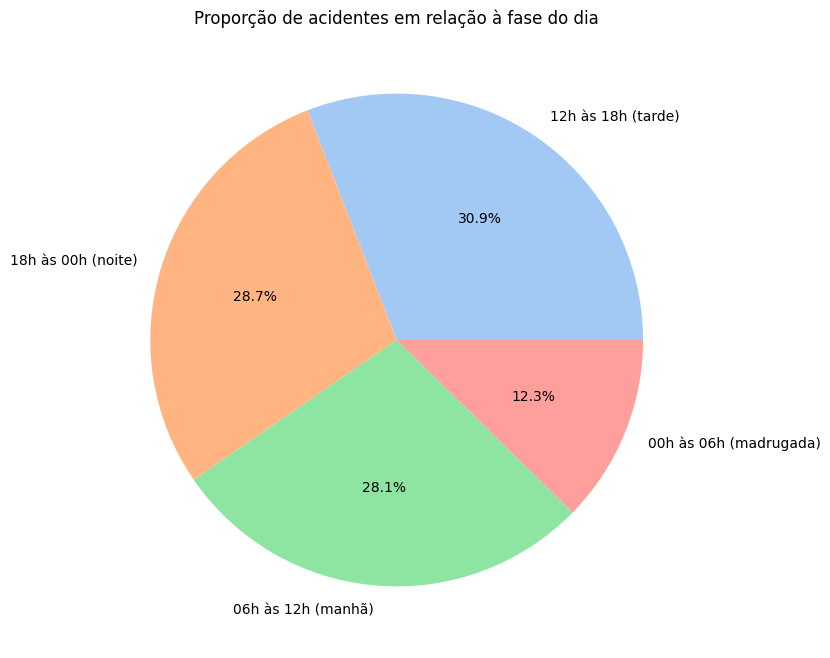

In [ ]:
df = df_accidents["fase_dia"].value_counts().reset_index()
df.columns = ["fase_dia", "frequencia"]
print(df)

draw_pie(
    df=df["frequencia"],
    labels=df["fase_dia"],
    title="Proporção de acidentes em relação à fase do dia"
)

#### Análise da distribuição de acidentes por condição meteorológica

  condicao_metereologica  frequencia
0              Céu Claro      262176
1                Nublado       71602
2                  Chuva       47194
3                    Sol       29038
4         Garoa/Chuvisco       15249
5       Nevoeiro/Neblina        3662
6                  Vento         824
7                Granizo          17
8                   Neve           7


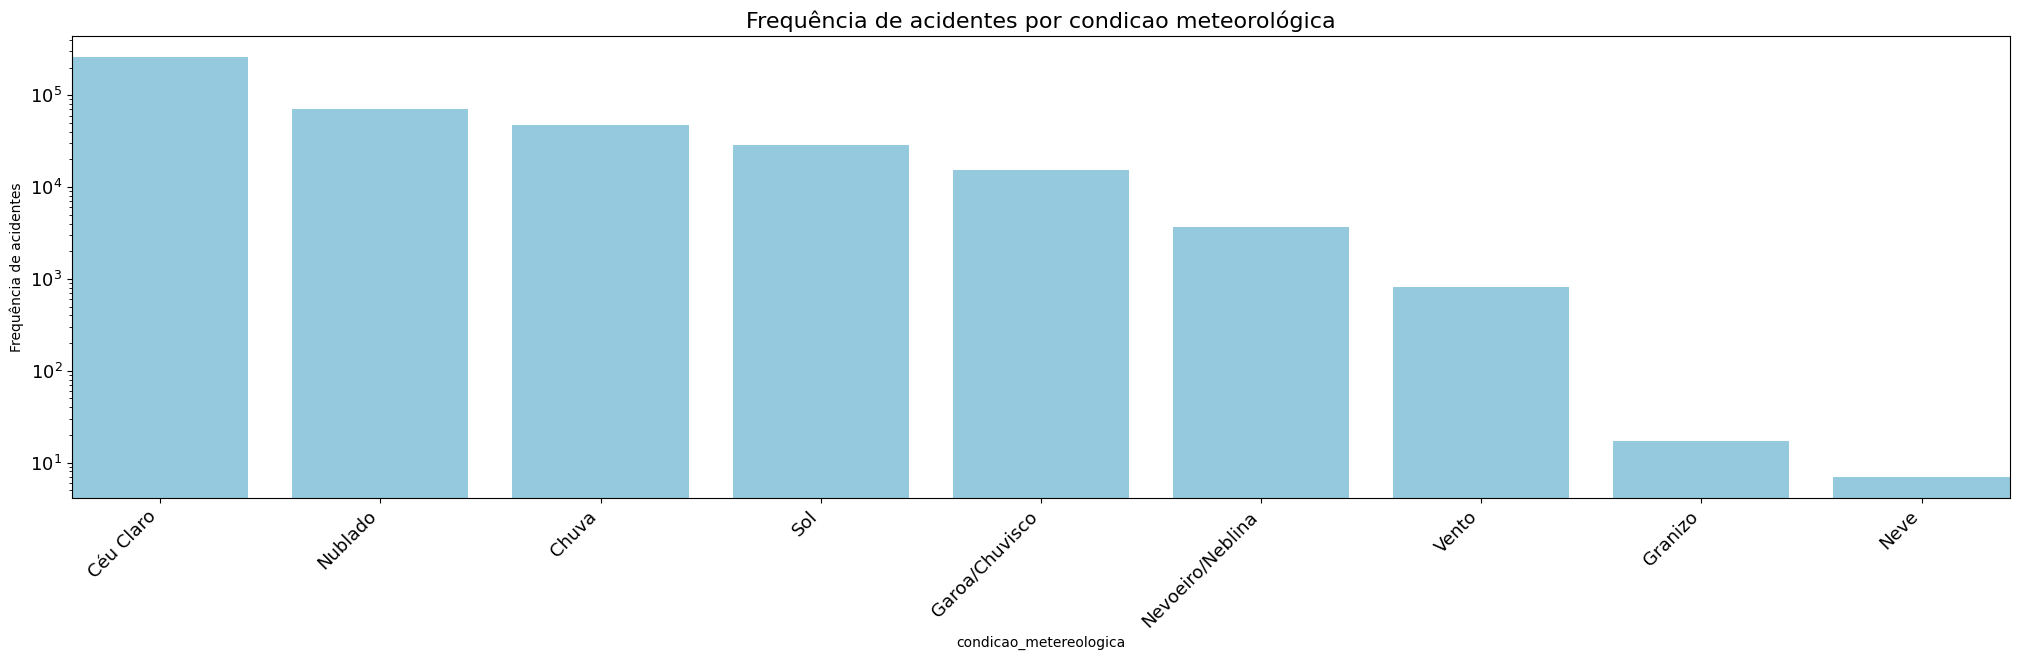

In [ ]:
df = df_accidents["condicao_metereologica"].value_counts().reset_index()
df.columns = ["condicao_metereologica", "frequencia"]
print(df)

draw_barplot(
    enable_lineplot=False,
    set_yscale=True,
    df=df,
    x="condicao_metereologica",
    y="frequencia",
    title="Frequência de acidentes por condicao meteorológica"
)

#### Análise da distribuição de maior número de acidentes por estado

uf
MG    55734
SC    51329
PR    47536
RJ    31817
RS    30168
SP    28668
BA    22961
GO    20756
PE    17850
ES    16053
MT    14707
MS    10224
PB    10113
CE     9796
RO     9377
RN     8949
PI     8220
MA     7190
DF     6359
PA     5883
AL     4088
TO     3799
SE     3573
AC     1563
RR     1311
AP      981
AM      764
Name: count, dtype: int64


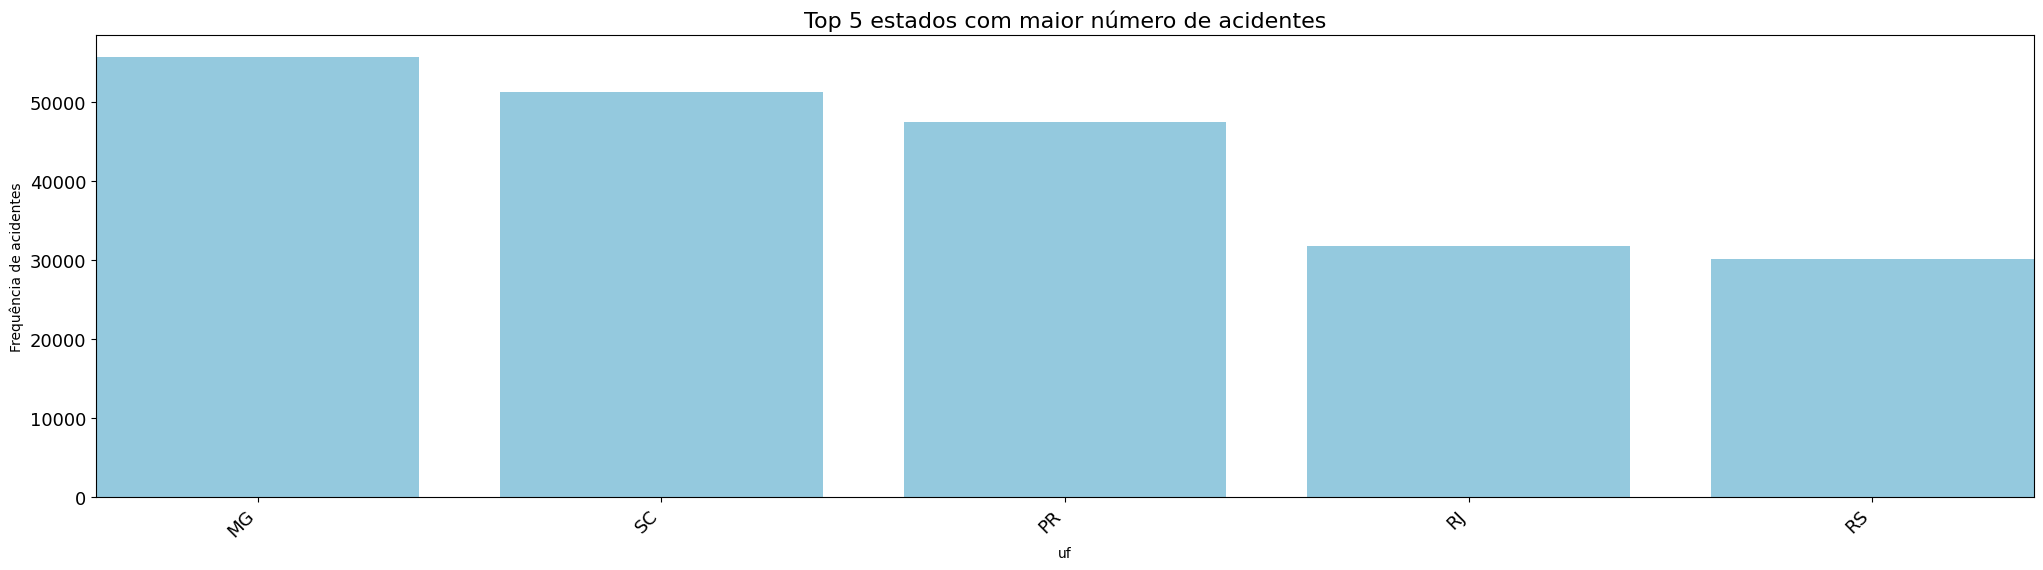

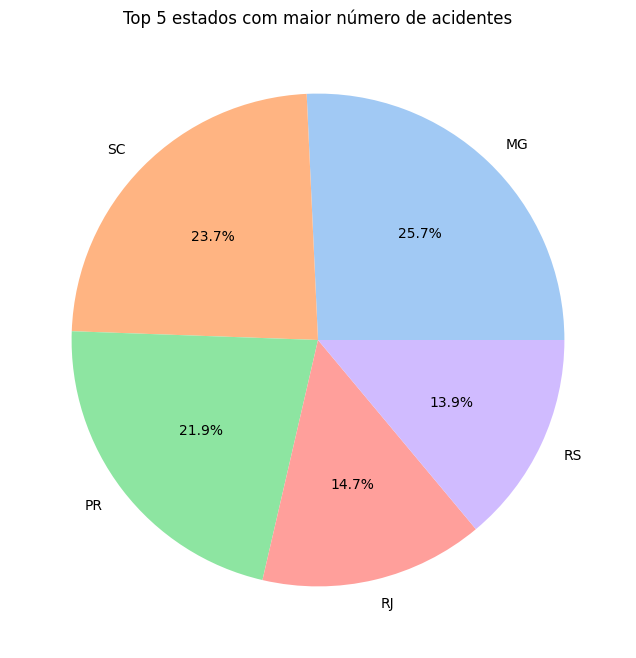

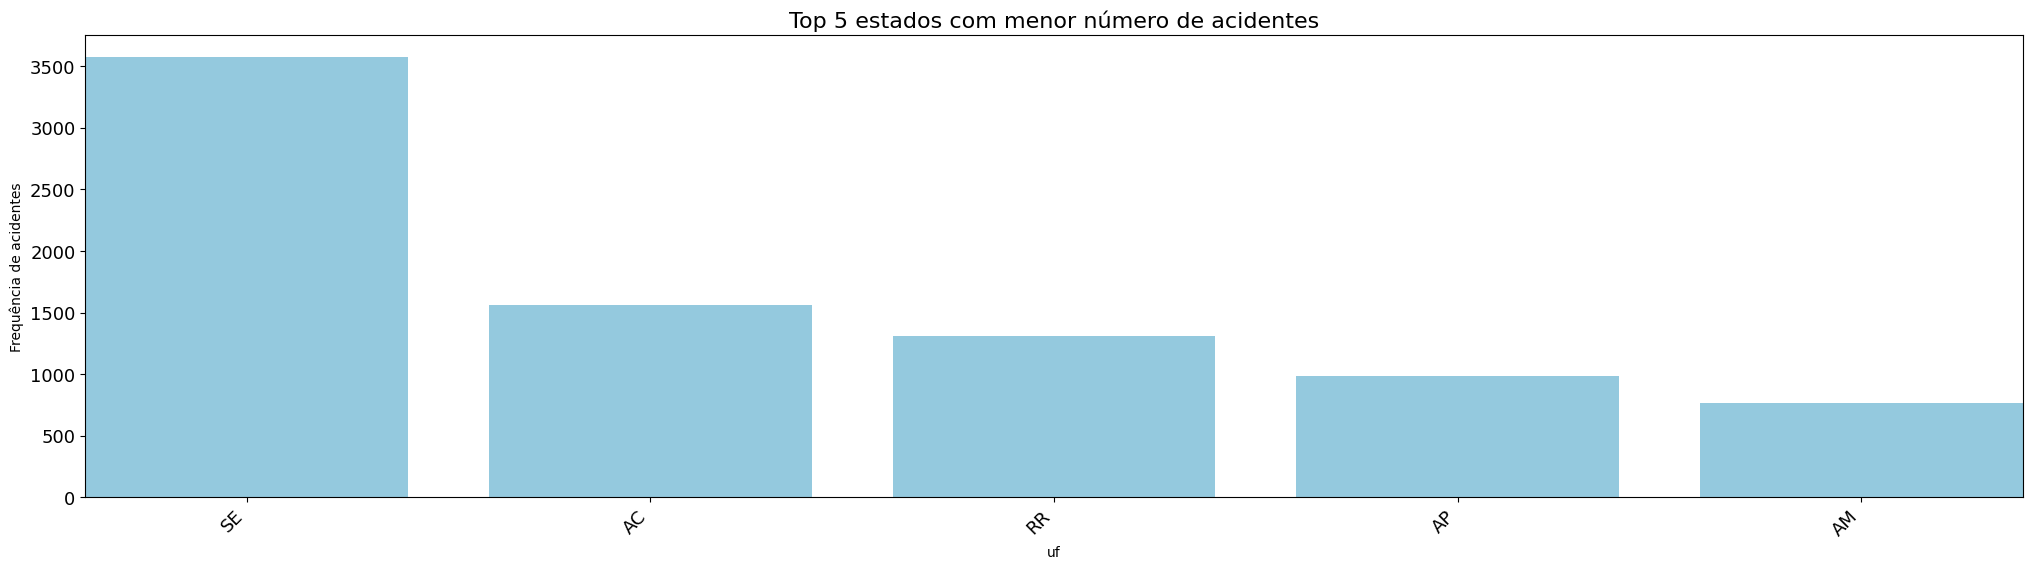

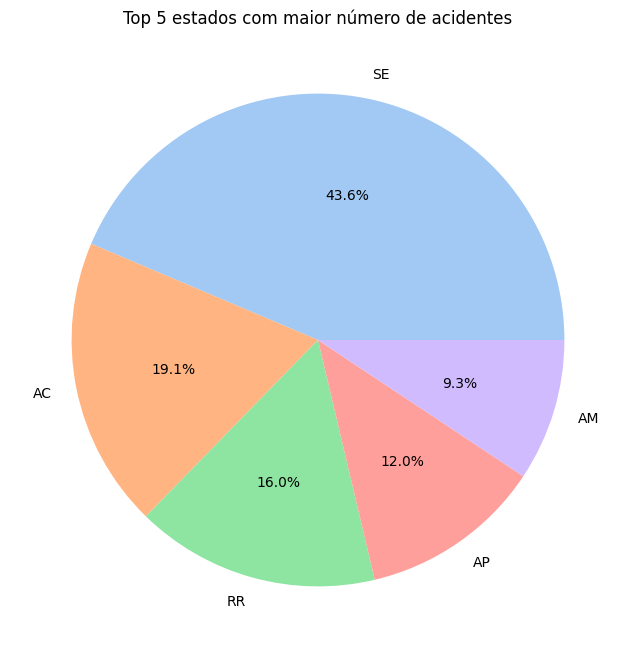

In [ ]:
df = df_accidents["uf"].value_counts()
print(df)

df_max = df.head(5).reset_index()
df_max.columns = ["uf", "frequencia"]

draw_barplot(
    enable_lineplot=False,
    set_yscale=False,
    df=df_max,
    x="uf",
    y="frequencia",
    title="Top 5 estados com maior número de acidentes"
)

draw_pie(
    df=df_max["frequencia"],
    labels=df_max["uf"],
    title="Top 5 estados com maior número de acidentes"
)

df_min = df.tail(5).reset_index()
df_min.columns = ["uf", "frequencia"]

draw_barplot(
    enable_lineplot=False,
    set_yscale=False,
    df=df_min,
    x="uf",
    y="frequencia",
    title="Top 5 estados com menor número de acidentes"
)

draw_pie(
    df=df_min["frequencia"],
    labels=df_min["uf"],
    title="Top 5 estados com maior número de acidentes"
)

#### Análise da distribuição de maior número de acidentes por rodovia

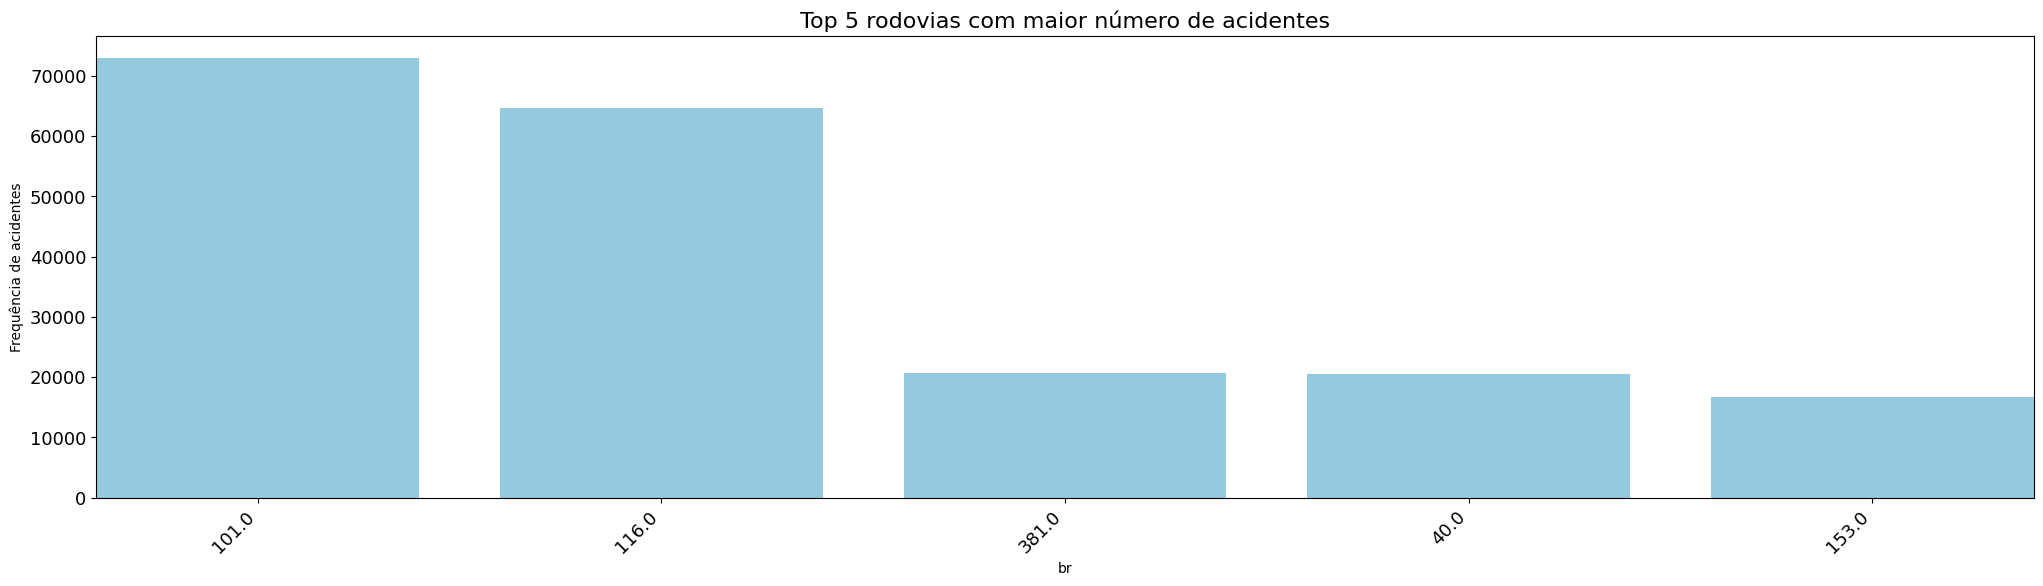

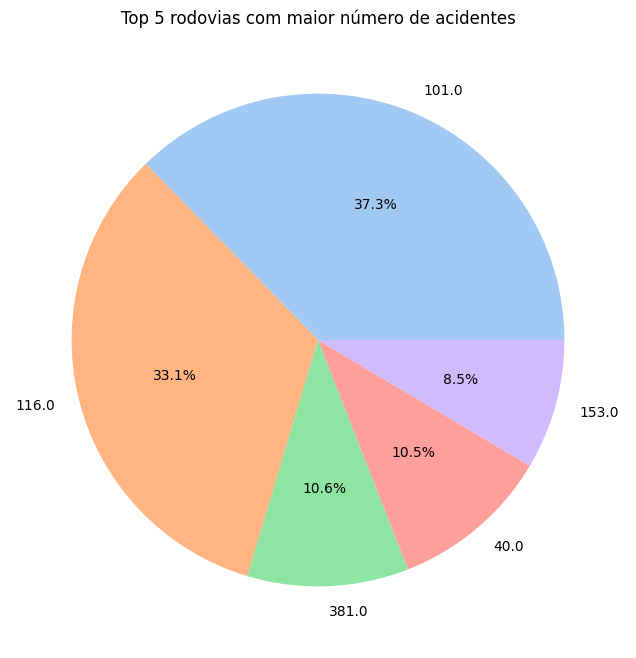

In [ ]:
df = df_accidents["br"].value_counts().head(5).reset_index()
df["br"] = pd.Categorical(df["br"], categories=df["br"], ordered=True)

df.columns = ["br", "frequencia"]

draw_barplot(
    enable_lineplot=False,
    set_yscale=False,
    df=df,
    x="br",
    y="frequencia",
    title="Top 5 rodovias com maior número de acidentes"
)

draw_pie(
    df=df["frequencia"],
    labels=df["br"],
    title="Top 5 rodovias com maior número de acidentes"
)

#### Análise da distribuição de maior número de acidentes por uso do solo

  uso_solo  frequencia
0    Rural      241770
1   Urbano      187999


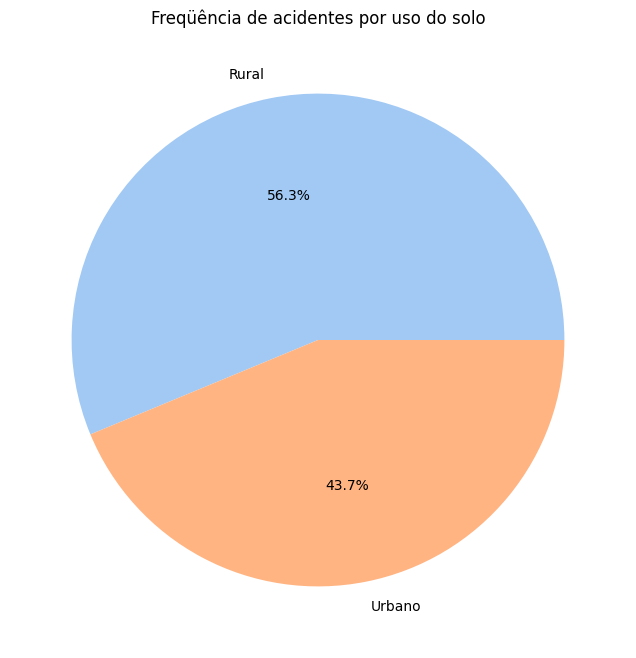

In [ ]:
df = df_accidents["uso_solo"].value_counts().reset_index()
df.columns = ["uso_solo", "frequencia"]
print(df)

draw_pie(
    df=df["frequencia"],
    labels=df["uso_solo"],
    title="Freqüência de acidentes por uso do solo"
)

#### Análise da distribuição de maior número de acidentes por tipo de pista

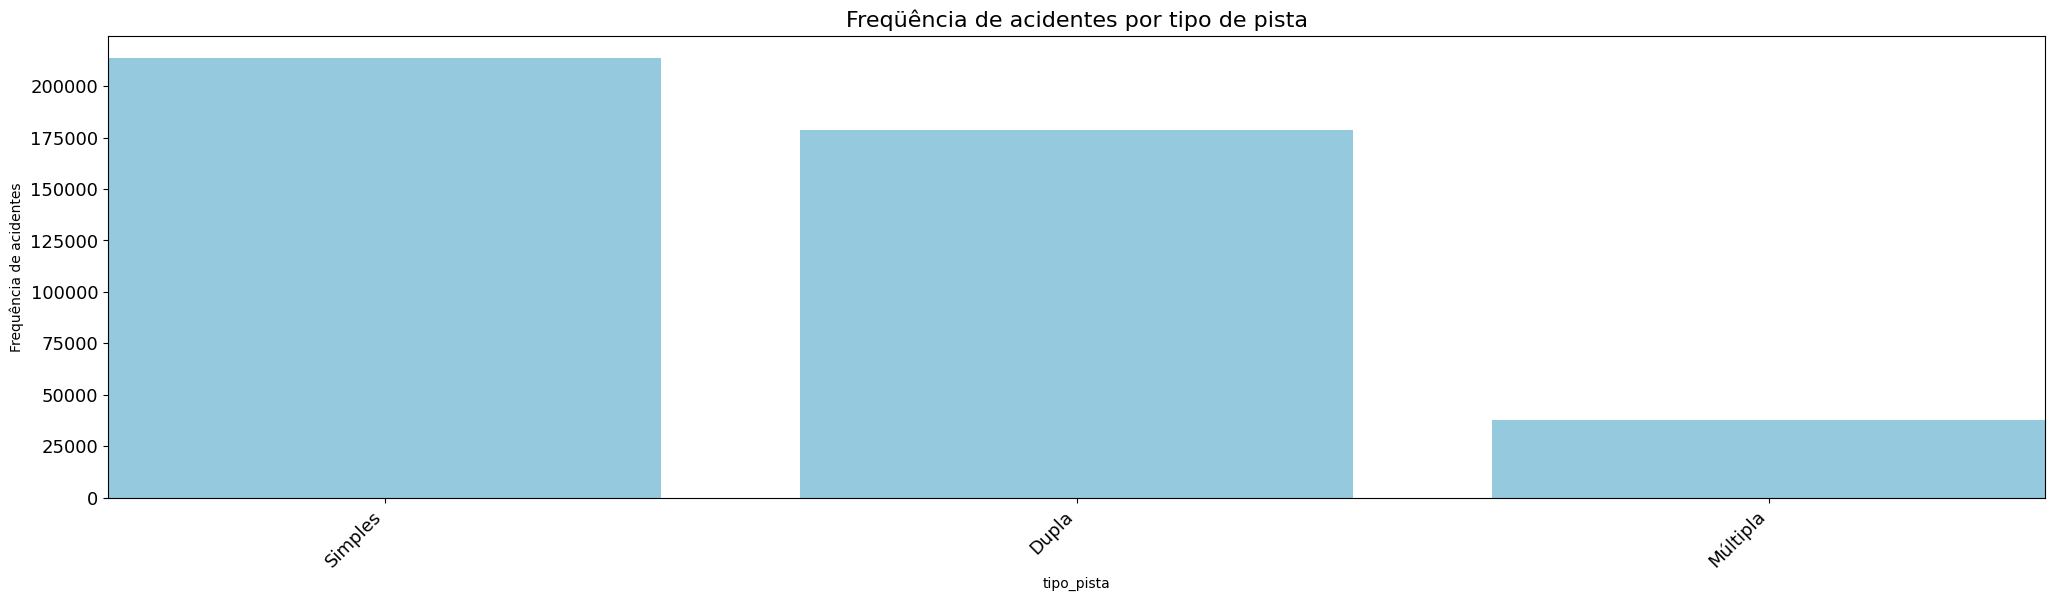

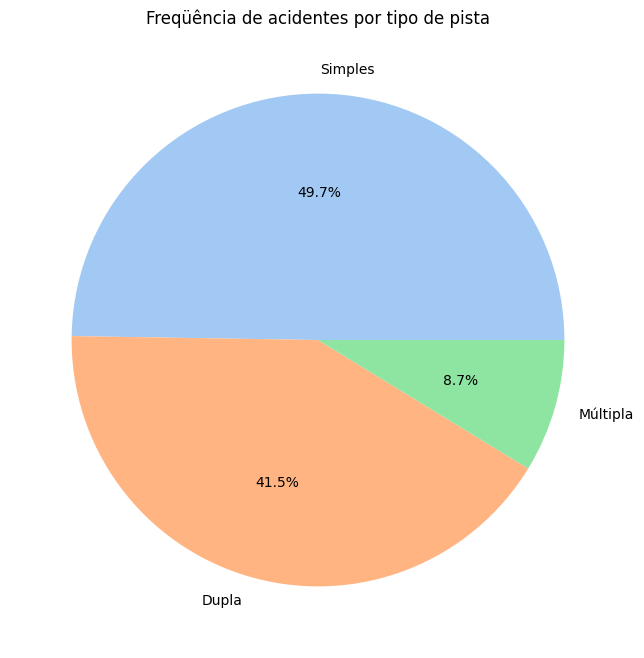

In [ ]:
df = df_accidents["tipo_pista"].value_counts().reset_index()
df.columns = ["tipo_pista", "frequencia"]

draw_barplot(
    enable_lineplot=False,
    set_yscale=False,
    df=df,
    x="tipo_pista",
    y="frequencia",
    title="Freqüência de acidentes por tipo de pista"
)

draw_pie(
    df=df["frequencia"],
    labels=df["tipo_pista"],
    title="Freqüência de acidentes por tipo de pista"
)

#### Análise da distribuição de maior número de acidentes por sentido da via

   sentido_via  frequencia
0    Crescente      230437
1  Decrescente      199332


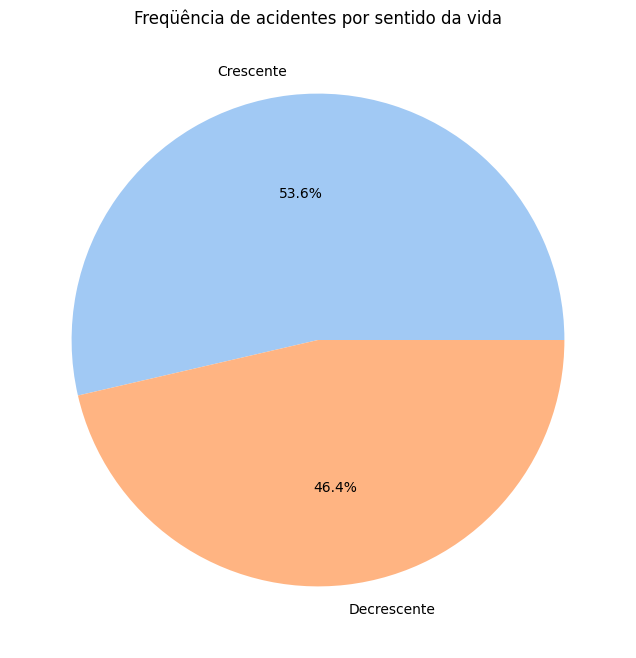

In [ ]:
df = df_accidents["sentido_via"].value_counts().reset_index()
df.columns = ["sentido_via", "frequencia"]
print(df)

draw_pie(
    df=df["frequencia"],
    labels=df["sentido_via"],
    title="Freqüência de acidentes por sentido da vida"
)

#### Análise da distribuição de maior número de acidentes por tipo de acidente

                      tipo_acidente  frequencia
0                  Colisão traseira       81317
1         Saída de leito carroçável       67526
2               Colisão transversal       54278
3                        Tombamento       35663
4                   Colisão frontal       28972
5                   Colisão lateral       24477
6     Colisão lateral mesmo sentido       23273
7         Atropelamento de pedestre       19885
8      Queda de ocupante de veículo       19182
9                Colisão com objeto       16729
10      Colisão com objeto estático       14144
11                      Capotamento       12119
12                         Incêndio        8093
13          Atropelamento de animal        7337
14                    Engavetamento        6732
15   Colisão lateral sentido oposto        6444
16            Derramamento de carga        1032
17                 Eventos atípicos        1014
18  Colisão com objeto em movimento         941
19                  Danos eventuais     

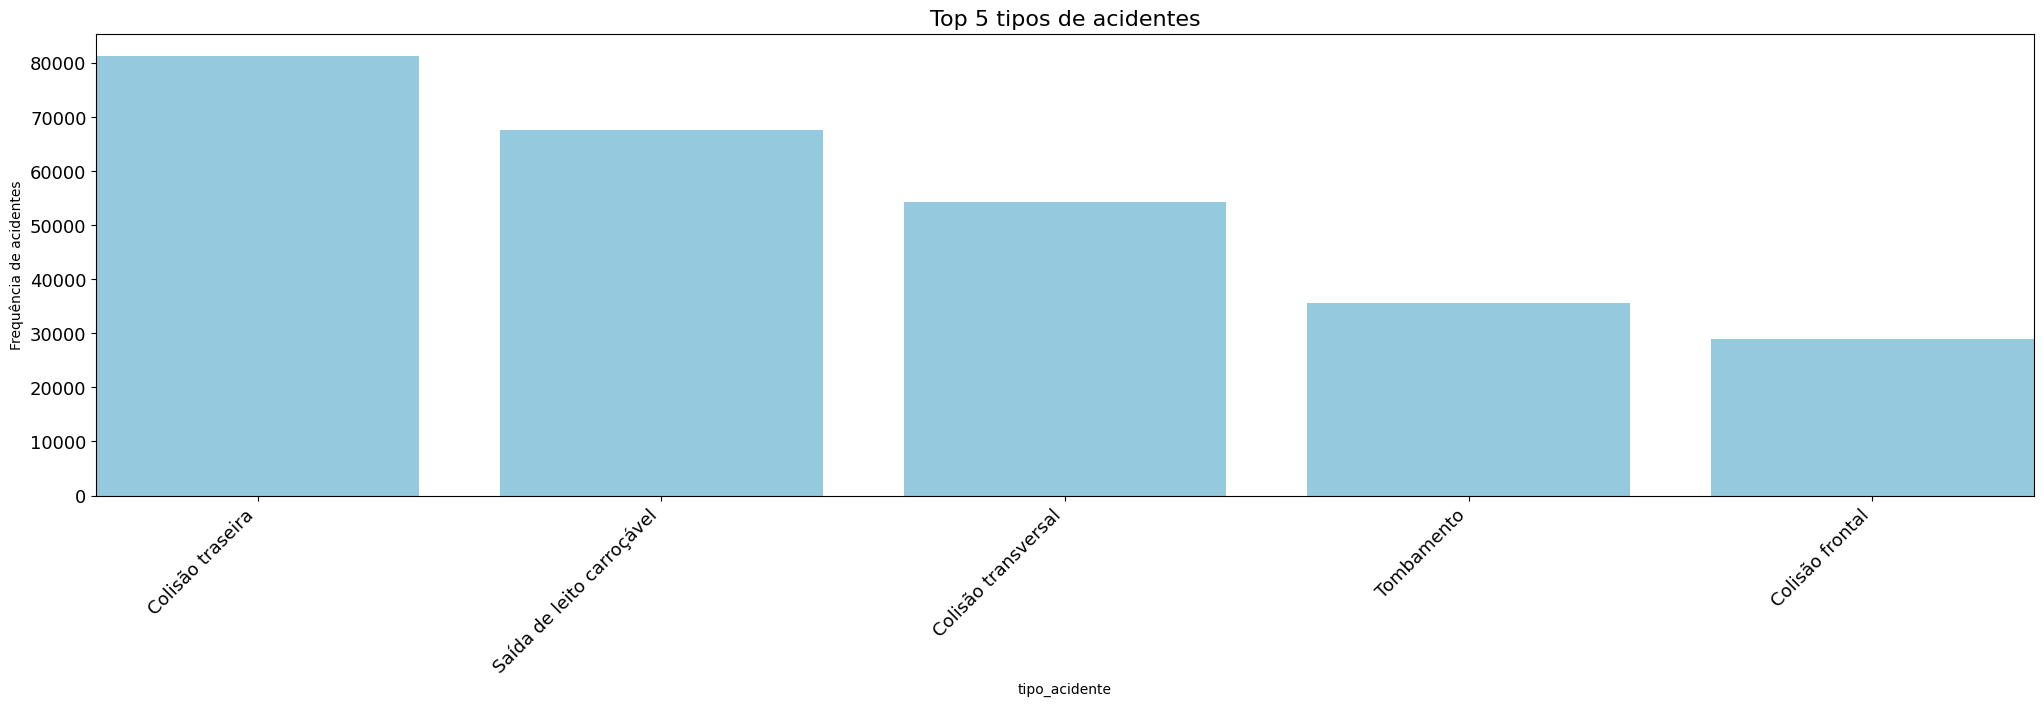

In [ ]:
df = df_accidents["tipo_acidente"].value_counts().reset_index()
df.columns = ["tipo_acidente", "frequencia"]
df.to_csv("results/tipo_acidente.csv", index=False)
print(df)

df.columns = ["tipo_acidente", "frequencia"]

df = df.head(5)
draw_barplot(
    enable_lineplot=False,
    set_yscale=False,
    df=df,
    x="tipo_acidente",
    y="frequencia",
    title="Top 5 tipos de acidentes"
)

#### Análise da distribuição de maior número de acidentes por causa de acidente

                                    causa_acidente  frequencia
0                      Falta de atenção à condução       71979
1                          Velocidade incompatível       35338
2         Reação tardia ou ineficiente do condutor       31715
3  Ingestão de álcool e/ou substâncias psicoativas       29596
4                   Ausência de reação do condutor       29345


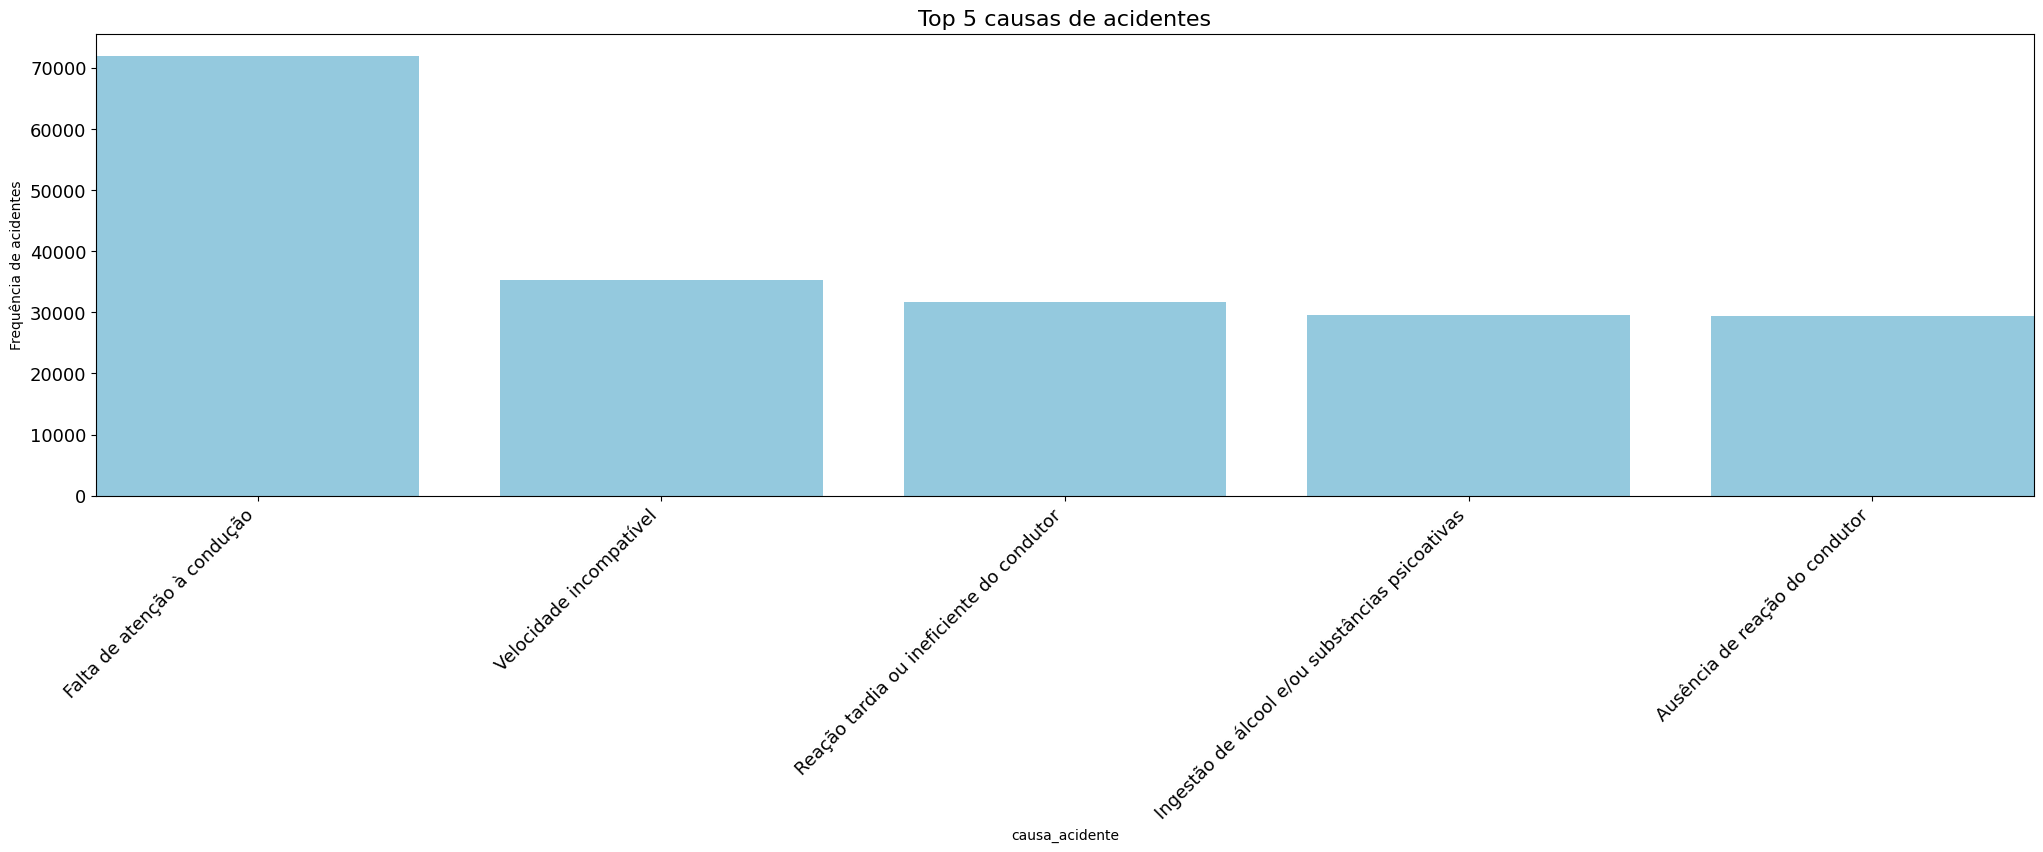

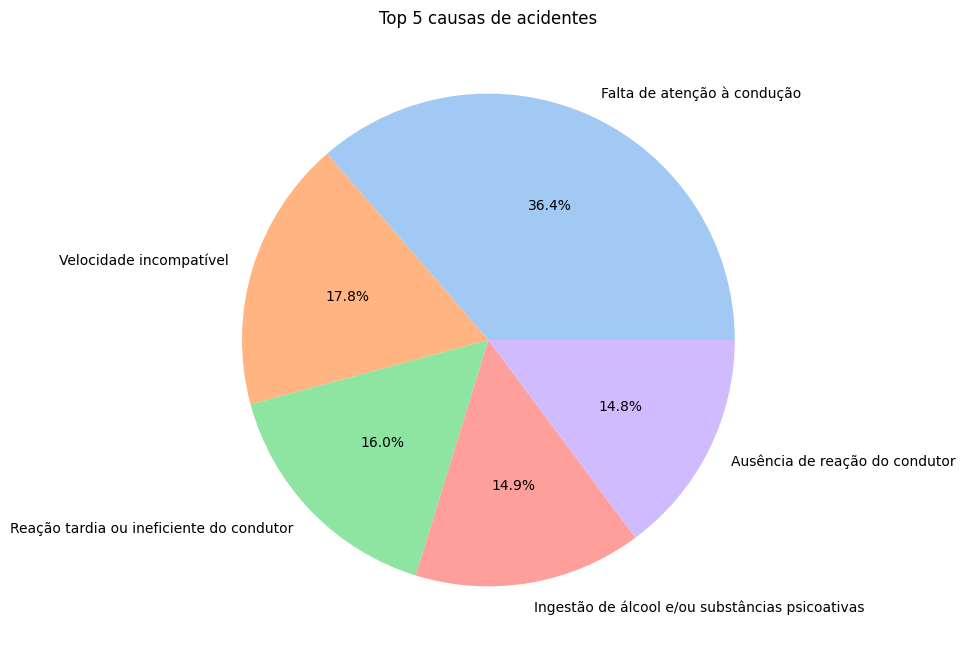

In [ ]:
df = df_accidents["causa_acidente"].value_counts().reset_index()
df.columns = ["causa_acidente", "frequencia"]
df.to_csv("results/causa_acidente.csv", index=False)
df = df.head(5)
print(df)

draw_barplot(
    enable_lineplot=False,
    set_yscale=False,
    df=df,
    x="causa_acidente",
    y="frequencia",
    title="Top 5 causas de acidentes"
)

draw_pie(
    df=df["frequencia"],
    labels=df["causa_acidente"],
    title="Top 5 causas de acidentes"
)

#### Análise da distribuição de maior número de acidentes por classificação de acidente

  classificacao_acidente  frequencia
0    Com vítimas feridas      323206
1            Sem vítimas       76672
2     Com vítimas fatais       29891


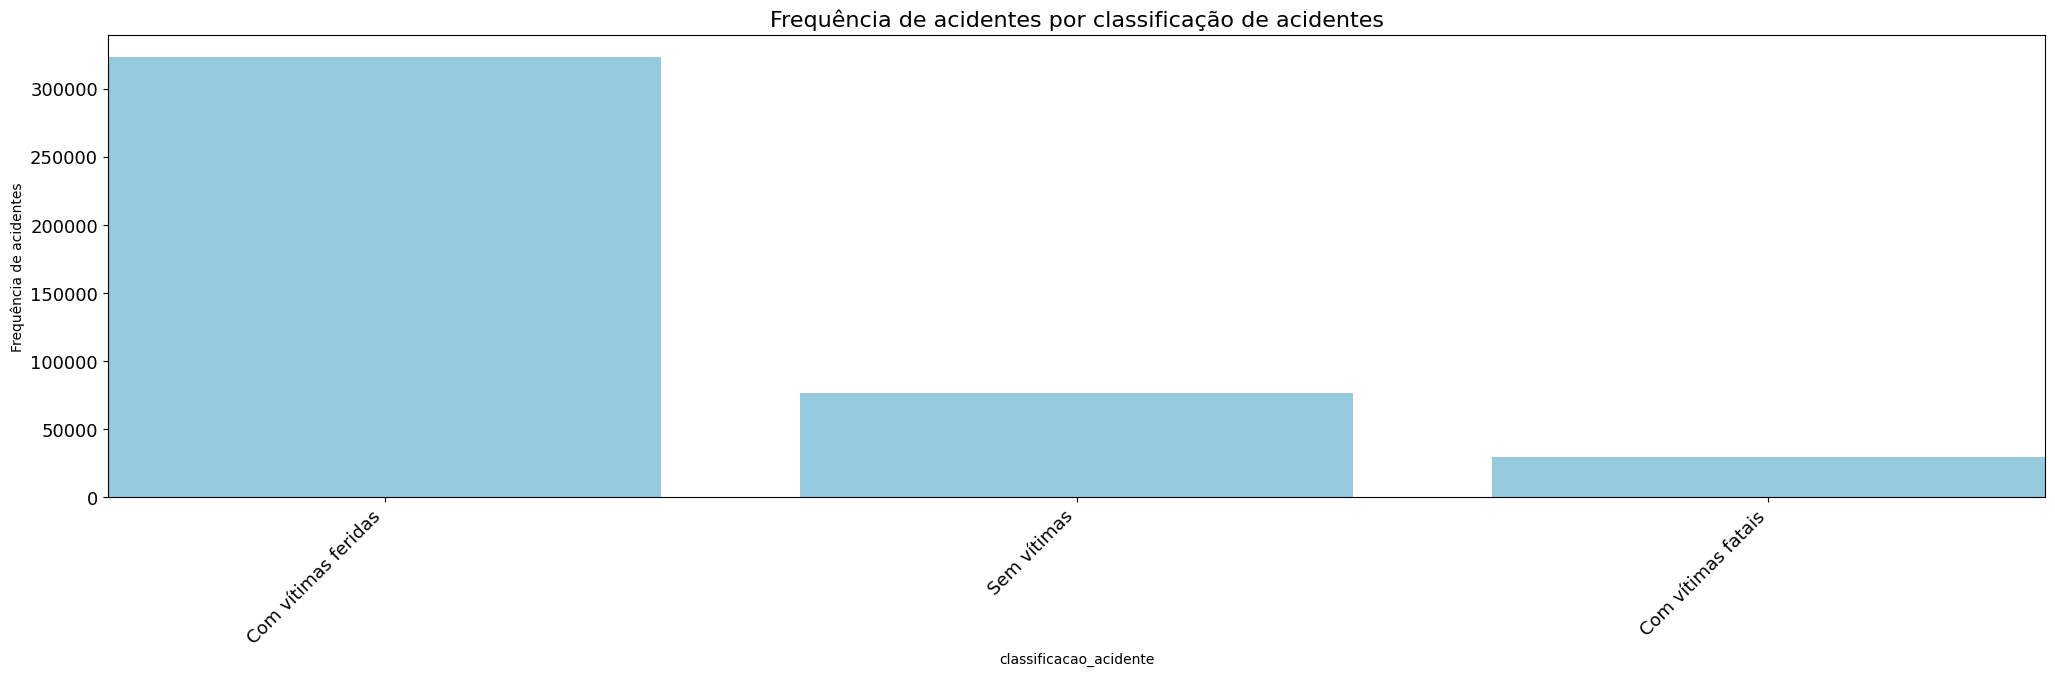

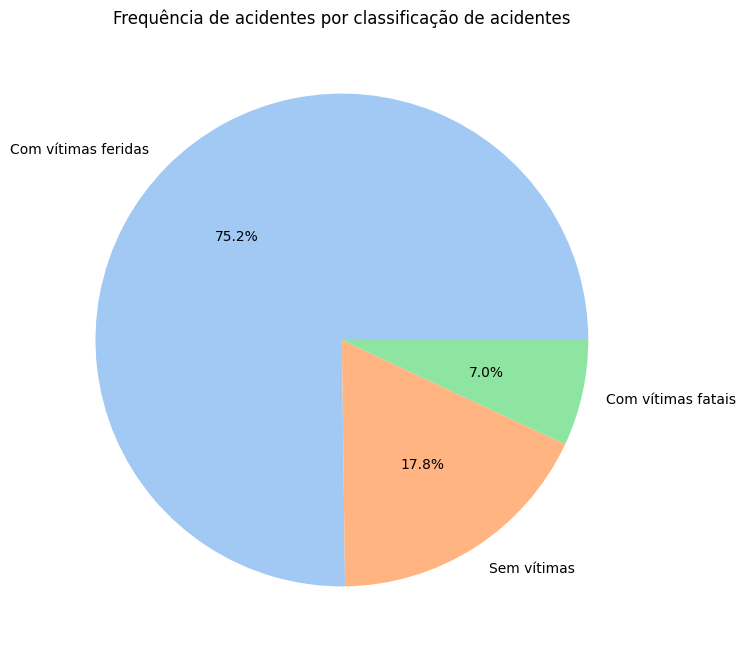

In [ ]:
df = df_accidents["classificacao_acidente"].value_counts().reset_index()
df.columns = ["classificacao_acidente", "frequencia"]
print(df)

draw_barplot(
    enable_lineplot=False,
    set_yscale=False,
    df=df,
    x="classificacao_acidente",
    y="frequencia",
    title="Frequência de acidentes por classificação de acidentes"
)

draw_pie(
    df=df["frequencia"],
    labels=df["classificacao_acidente"],
    title="Frequência de acidentes por classificação de acidentes"
)

#### Análise da distribuição de acidentes por pessoas

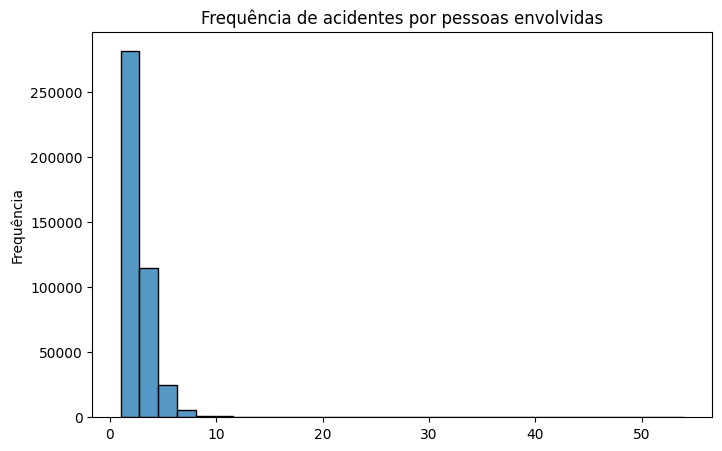

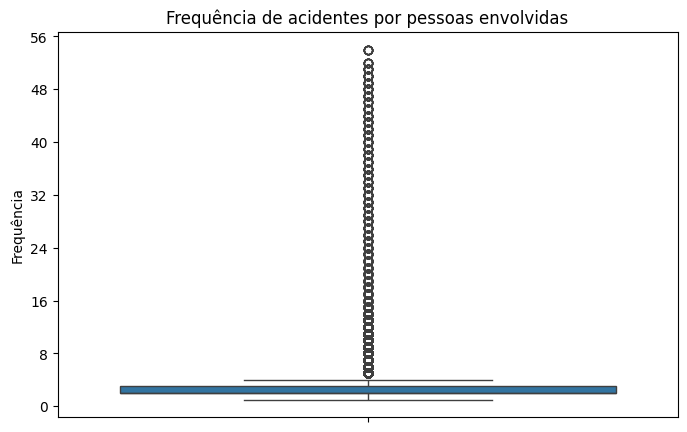

In [ ]:
draw_histplot(
    df=df_accidents["pessoas"],
    bins=30,
    title="Frequência de acidentes por pessoas envolvidas",
)

draw_boxplot(
    df=df_accidents["pessoas"].reset_index(),
    multipleLocator=8,
    title="Frequência de acidentes por pessoas envolvidas"
)

#### Análise da distribuição de acidentes por veículos

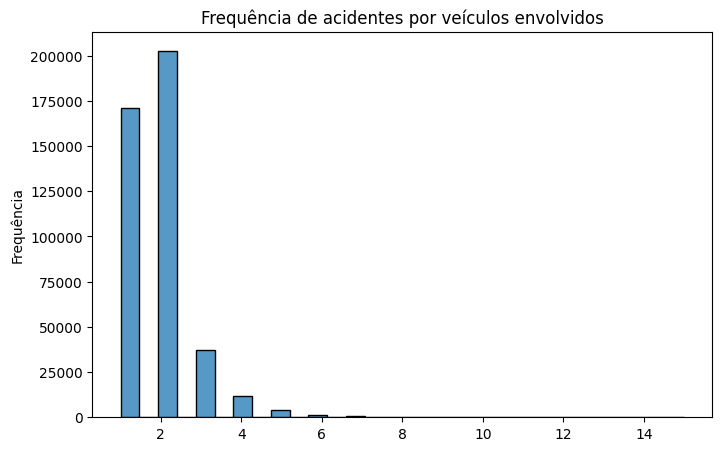

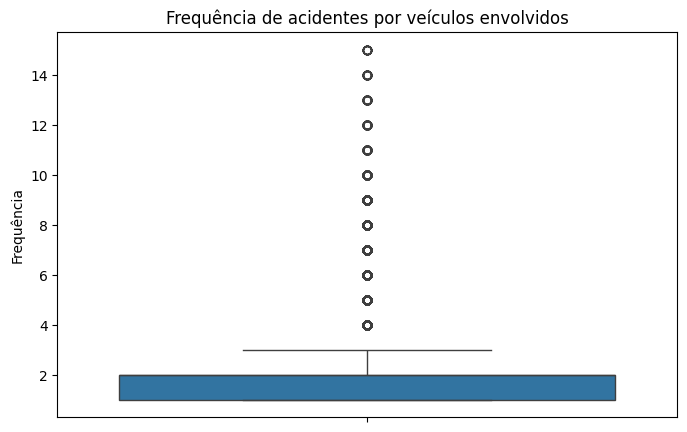

In [ ]:
draw_histplot(
    df=df_accidents["veiculos"],
    bins=30,
    title="Frequência de acidentes por veículos envolvidos",
)

draw_boxplot(
    df=df_accidents["veiculos"].reset_index(),
    multipleLocator=2,
    title="Frequência de acidentes por veículos envolvidos"
)

## Análise bivariada

### Tipo de acidente

#### tipo_acidente x tipo_data

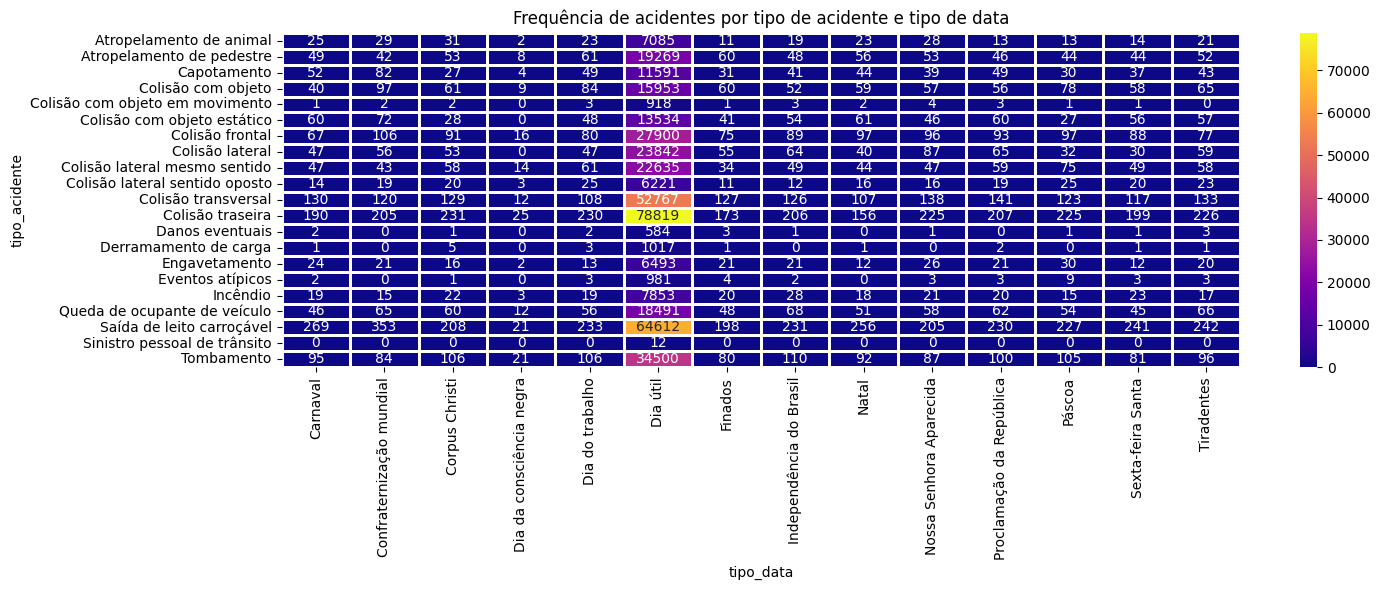

In [ ]:
df = df_accidents.copy()
df = df.groupby(['tipo_acidente', 'tipo_data']).size().unstack().fillna(0)


plt.figure(figsize=(15, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por tipo de acidente e tipo de data")
plt.tight_layout()
plt.show()

#### tipo_acidente x mes_ano (ano)

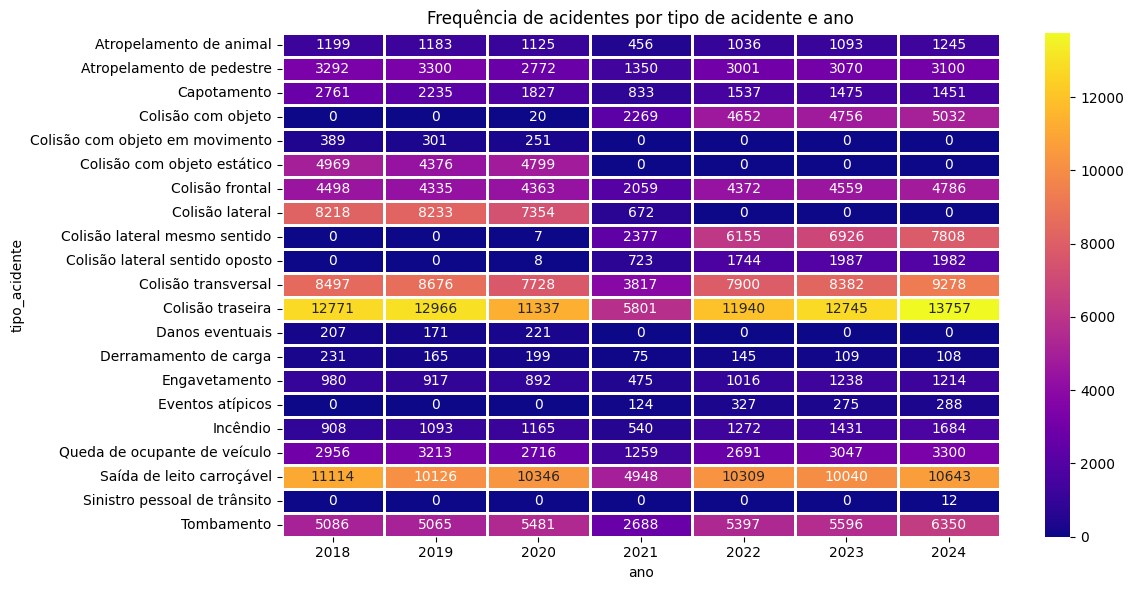

In [ ]:
df = df_accidents.copy()
df["mes_ano"] = df["mes_ano"].dt.year
df = df.groupby(['tipo_acidente', 'mes_ano']).size().unstack().fillna(0)
df.columns.name = "ano"

plt.figure(figsize=(12, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por tipo de acidente e ano")
plt.tight_layout()
plt.show()

#### tipo_acidente x mes_ano (mes)

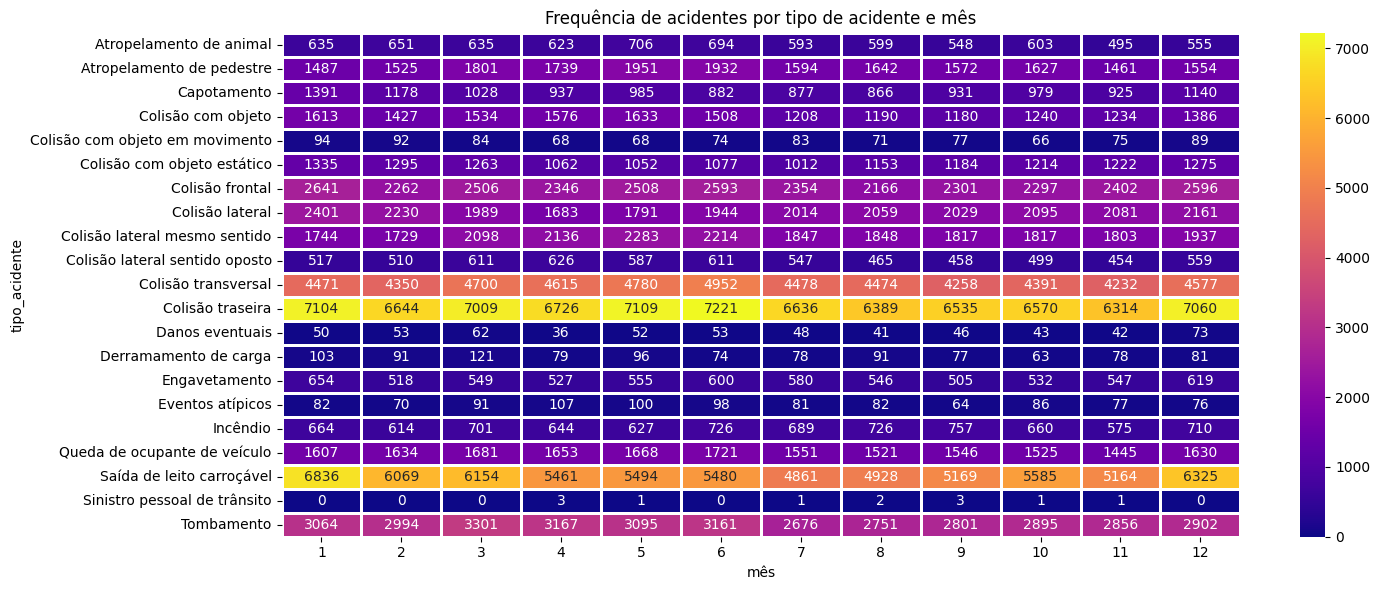

In [ ]:
df = df_accidents.copy()
df["mes_ano"] = df["mes_ano"].dt.month
df = df.groupby(['tipo_acidente', 'mes_ano']).size().unstack().fillna(0)
df.columns.name = "mês"

plt.figure(figsize=(15, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por tipo de acidente e mês")
plt.tight_layout()
plt.show()

#### tipo_acidente x dia_semana

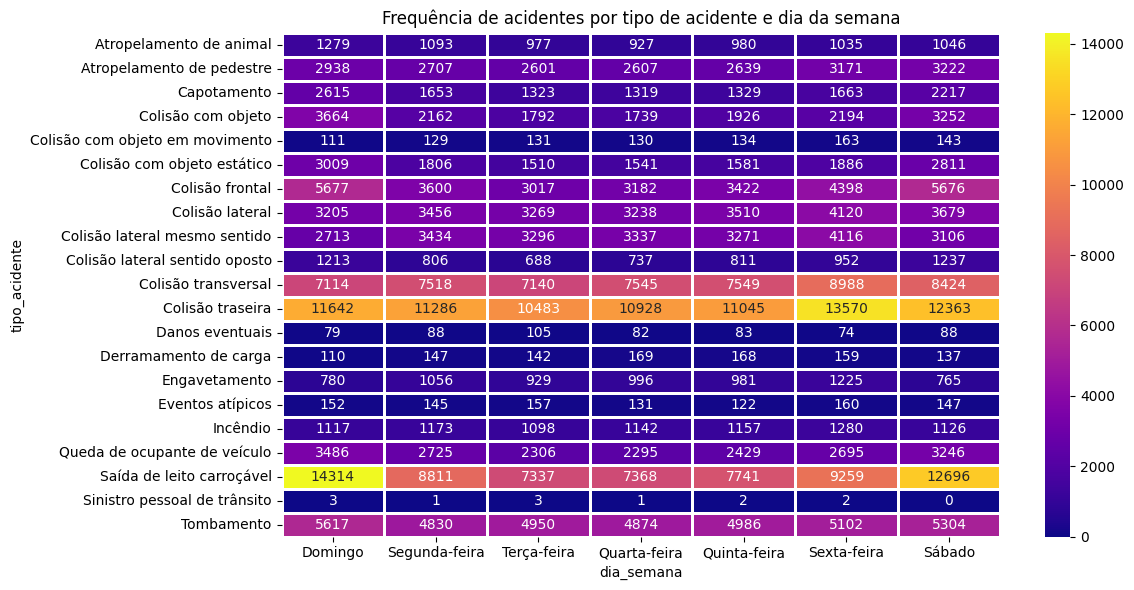

In [ ]:
df = df_accidents.copy()
df = df.groupby(['tipo_acidente', 'dia_semana']).size().unstack().fillna(0)
df = df[get_weekdays()]

plt.figure(figsize=(12, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por tipo de acidente e dia da semana")
plt.tight_layout()
plt.show()

#### tipo_acidente x horario

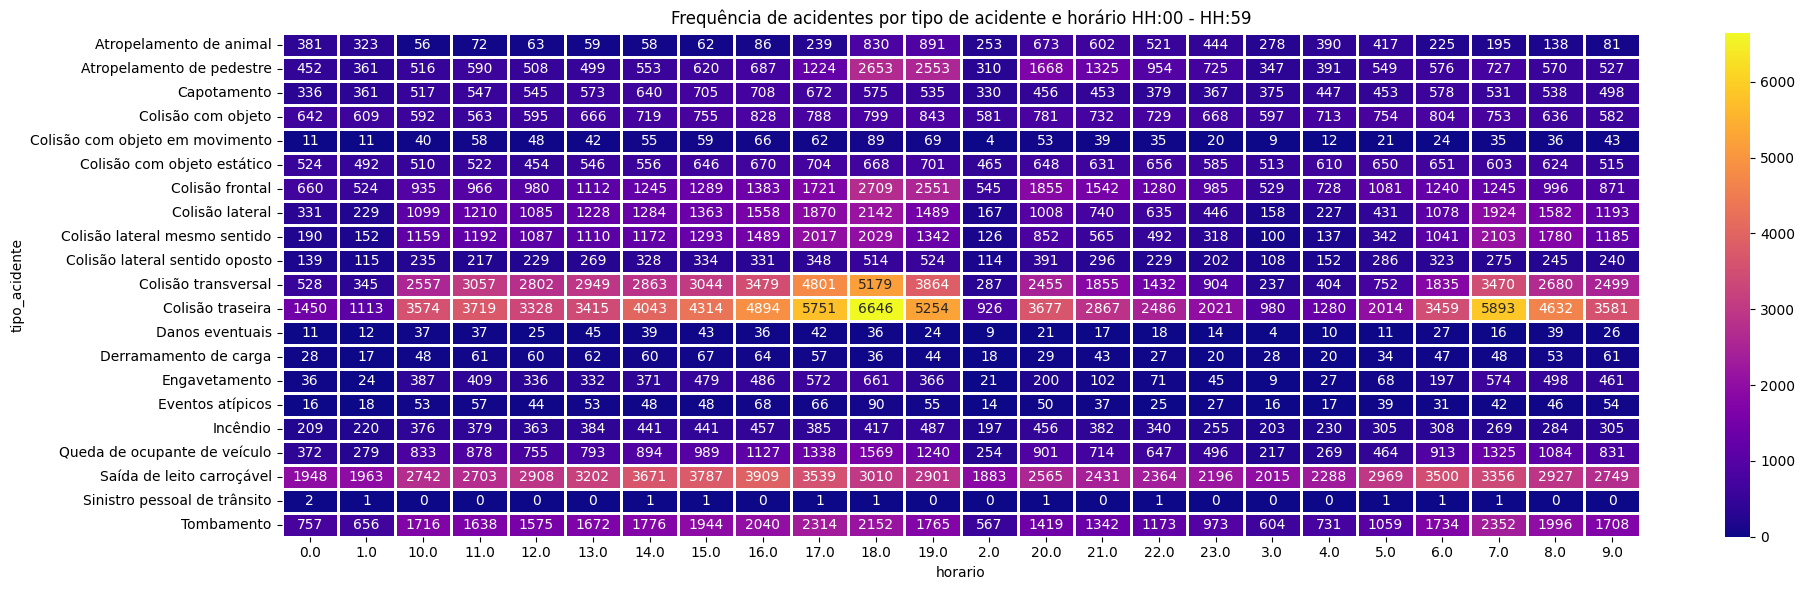

In [ ]:
df = df_accidents.copy()
df.loc[:, "horario"] = to_datetime(df["horario"]).astype(str).str.zfill(2)
df = df.groupby(['tipo_acidente', 'horario']).size().unstack().fillna(0)

plt.figure(figsize=(20, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por tipo de acidente e horário HH:00 - HH:59")
plt.tight_layout()
plt.show()

#### tipo_acidente x fase_dia

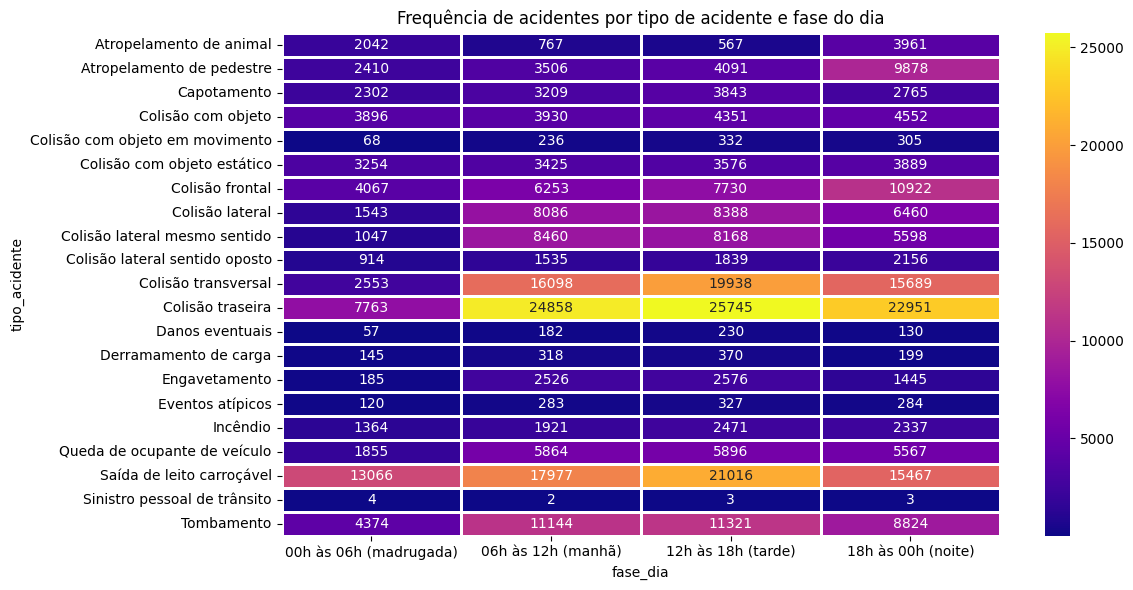

In [ ]:
df = df_accidents.copy()
df = df.groupby(['tipo_acidente', 'fase_dia']).size().unstack().fillna(0)


plt.figure(figsize=(12, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por tipo de acidente e fase do dia")
plt.tight_layout()
plt.show()

#### tipo_acidente x condicao_metereologica

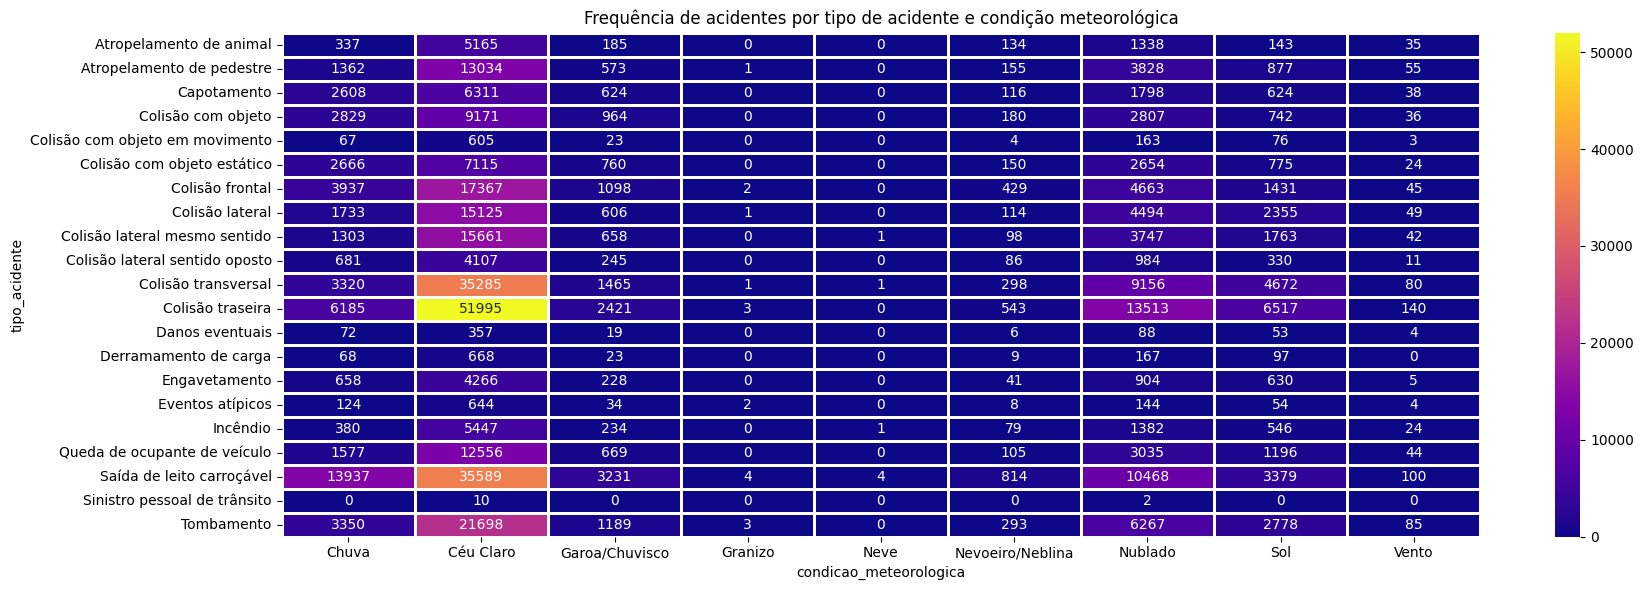

In [ ]:
df = df_accidents.copy()
df = df.groupby(['tipo_acidente', 'condicao_metereologica']).size().unstack().fillna(0)
df.columns.name = "condicao_meteorologica"

plt.figure(figsize=(18, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por tipo de acidente e condição meteorológica")
plt.tight_layout()
plt.show()

#### tipo_acidente x uf

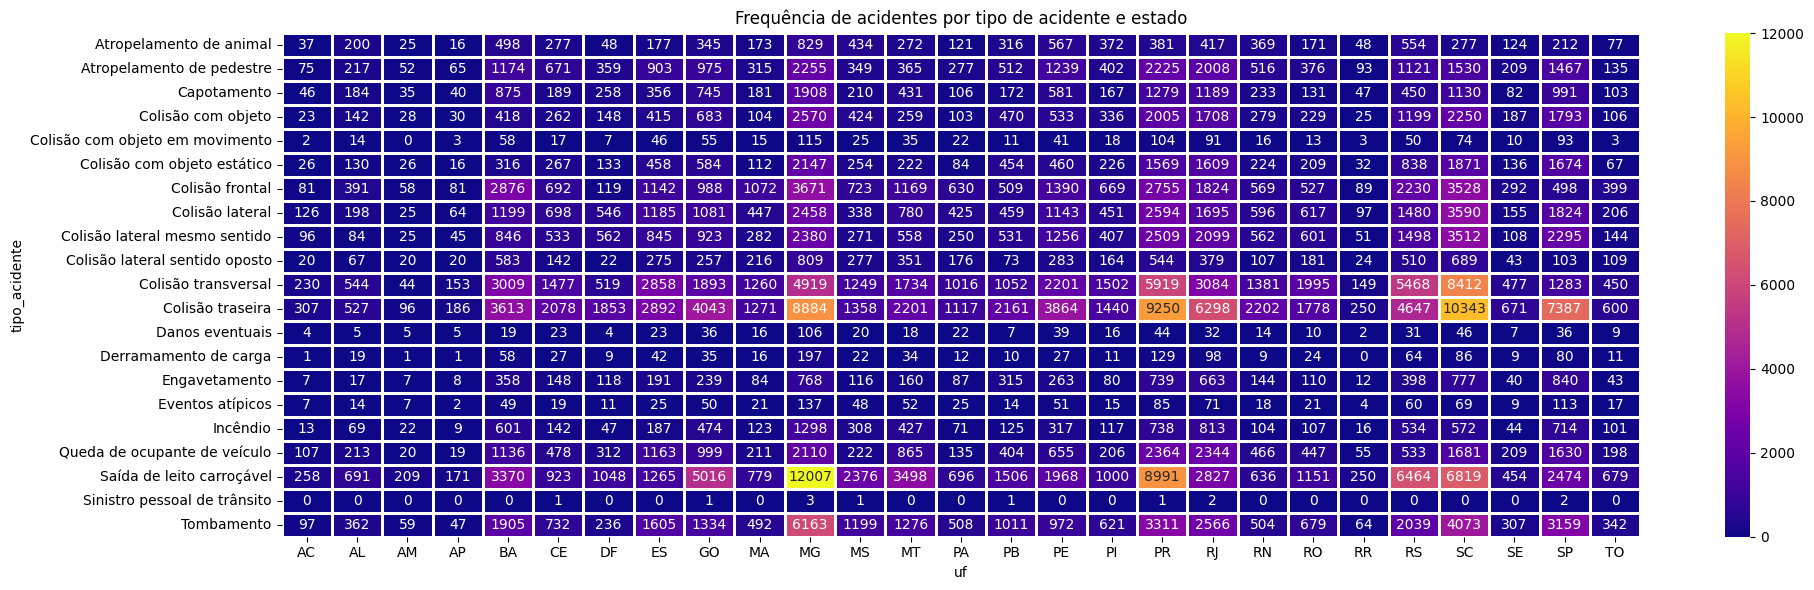

In [ ]:
df = df_accidents.copy()
df = df.groupby(['tipo_acidente', 'uf']).size().unstack().fillna(0)

plt.figure(figsize=(20, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por tipo de acidente e estado")
plt.tight_layout()
plt.show()

#### tipo_acidente x br (radiais)

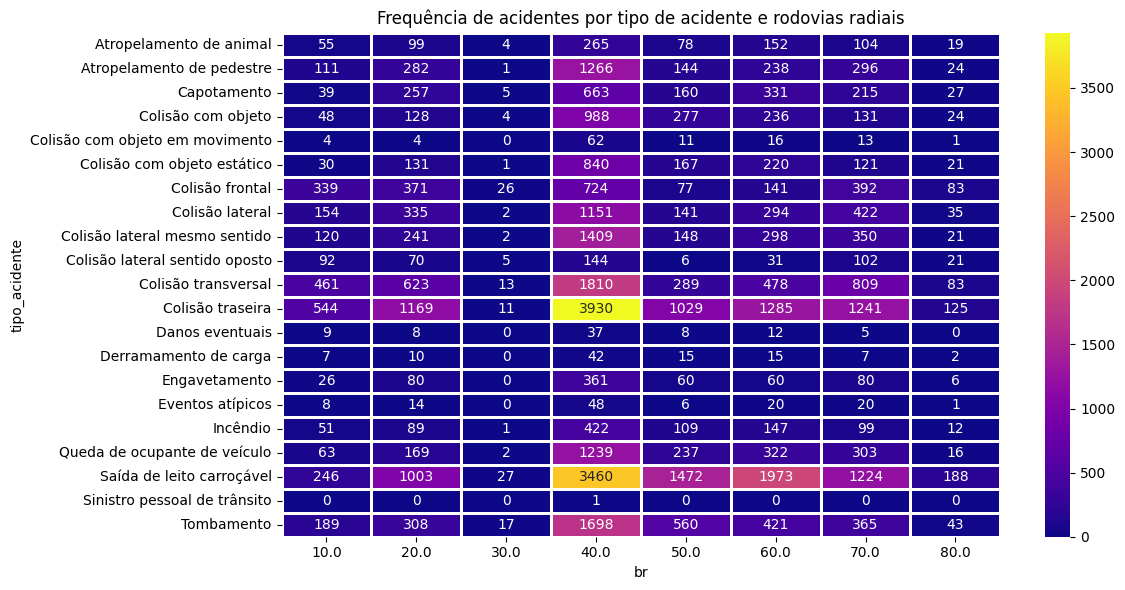

In [ ]:
min, max = 10, 99

df = df_accidents.copy()
df = df.groupby(['tipo_acidente', 'br']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(12, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por tipo de acidente e rodovias radiais")
plt.tight_layout()
plt.show()

#### tipo_acidente x br (longitudinais)

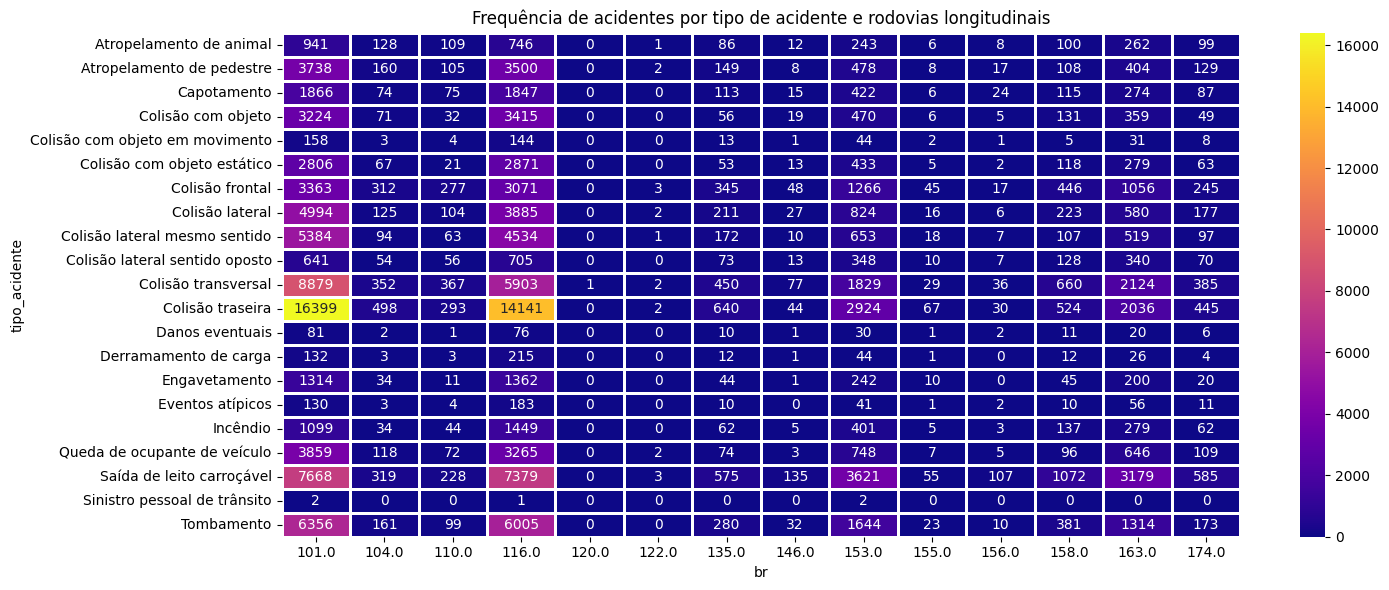

In [ ]:
min, max = 100, 199

df = df_accidents.copy()
df = df.groupby(['tipo_acidente', 'br']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(15, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por tipo de acidente e rodovias longitudinais")
plt.tight_layout()
plt.show()

#### tipo_acidente x br (transversais)

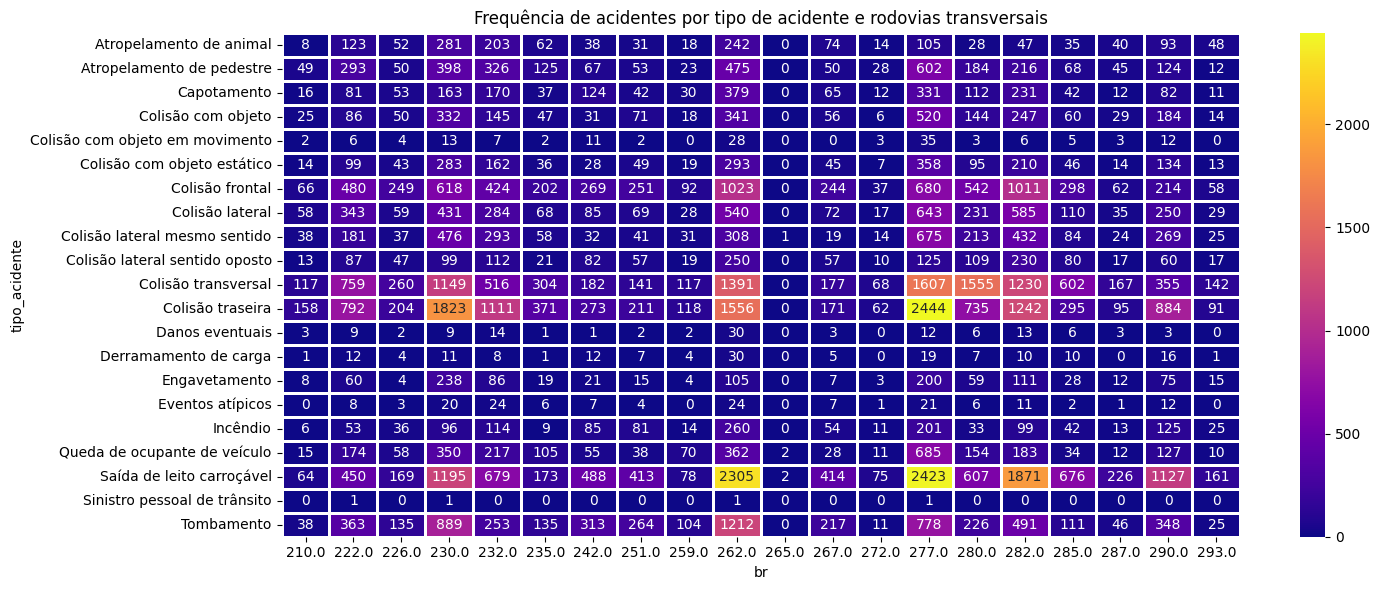

In [ ]:
min, max = 200, 299

df = df_accidents.copy()
df = df.groupby(['tipo_acidente', 'br']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(15, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por tipo de acidente e rodovias transversais")
plt.tight_layout()
plt.show()

#### tipo_acidente x br (diagonais)

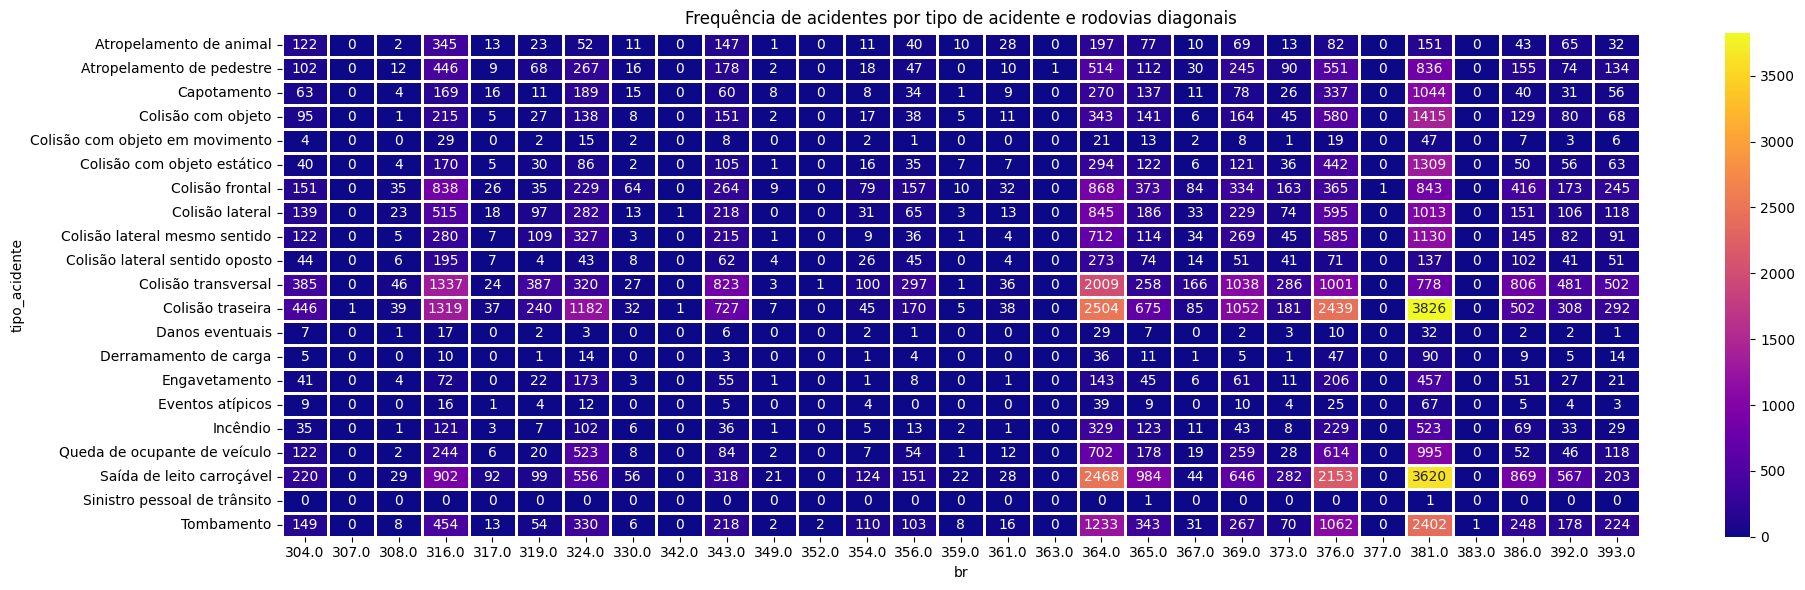

In [ ]:
min, max = 300, 399

df = df_accidents.copy()
df = df.groupby(['tipo_acidente', 'br']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(20, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por tipo de acidente e rodovias diagonais")
plt.tight_layout()
plt.show()

#### tipo_acidente x br (de ligação)

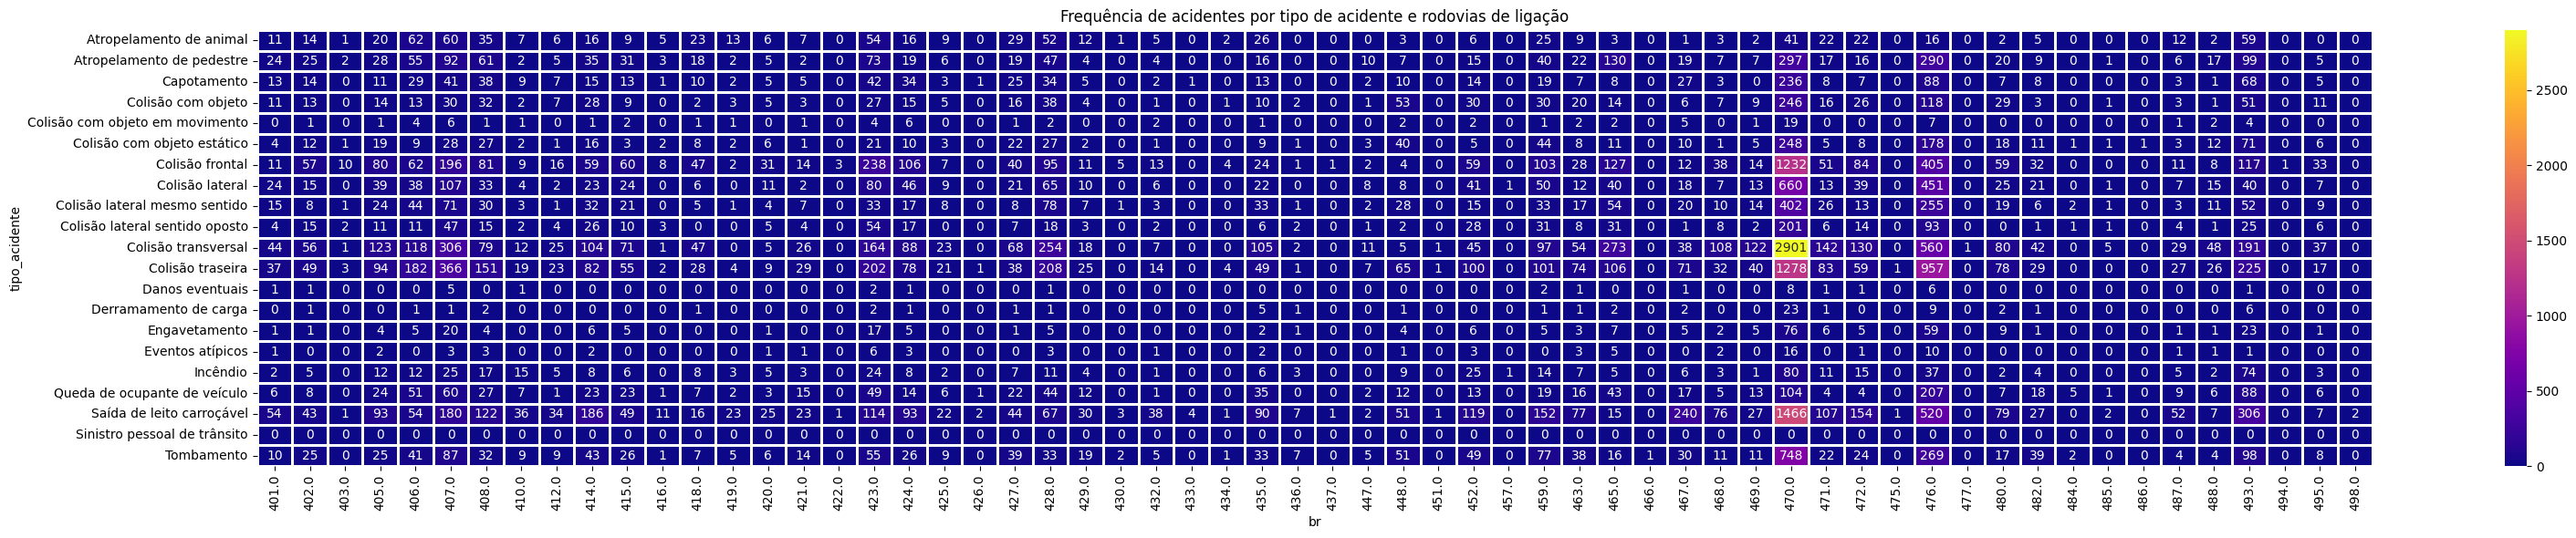

In [ ]:
min, max = 400, 499

df = df_accidents.copy()
df = df.groupby(['tipo_acidente', 'br']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(32, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por tipo de acidente e rodovias de ligação")
plt.tight_layout()
plt.show()

#### tipo_acidente x uso_solo

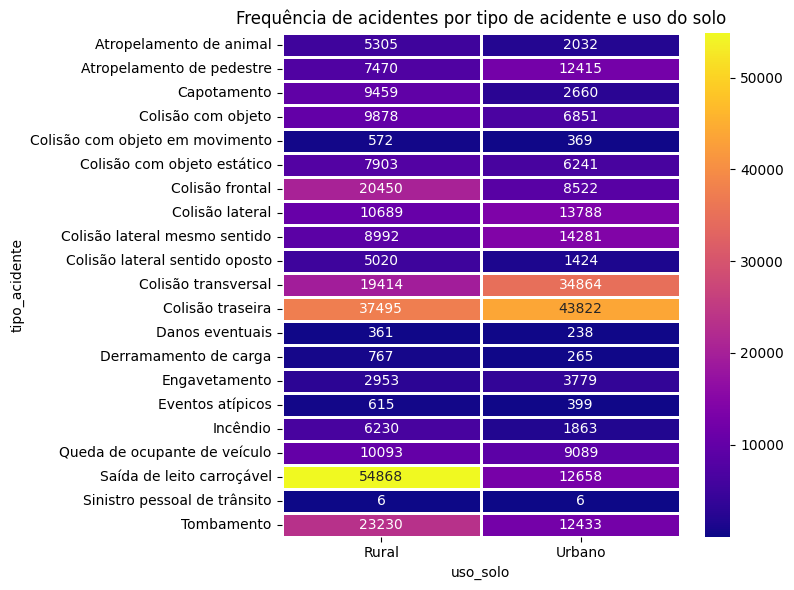

In [ ]:
df = df_accidents.copy()
df = df.groupby(['tipo_acidente', 'uso_solo']).size().unstack().fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por tipo de acidente e uso do solo")
plt.tight_layout()
plt.show()

#### tipo_acidente x tipo_pista

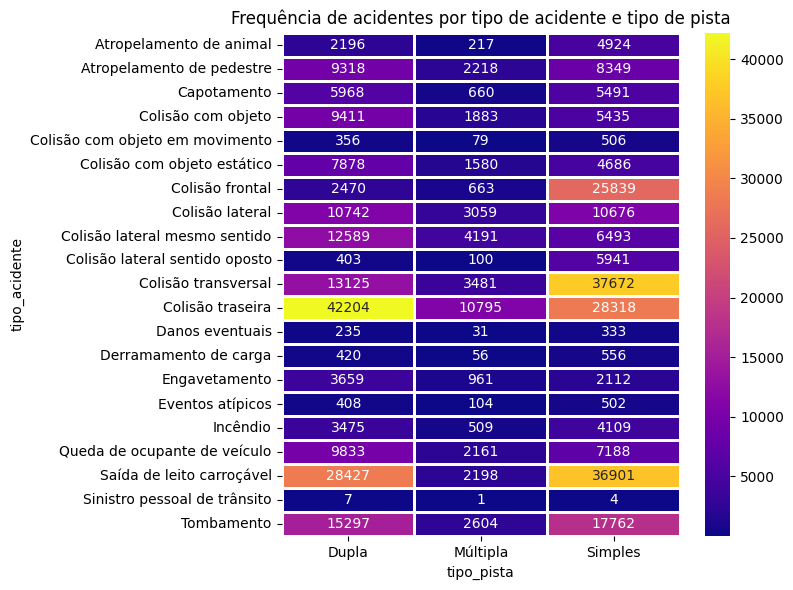

In [ ]:
df = df_accidents.copy()
df = df.groupby(['tipo_acidente', 'tipo_pista']).size().unstack().fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por tipo de acidente e tipo de pista")
plt.tight_layout()
plt.show()

#### tipo_acidente x sentido_via

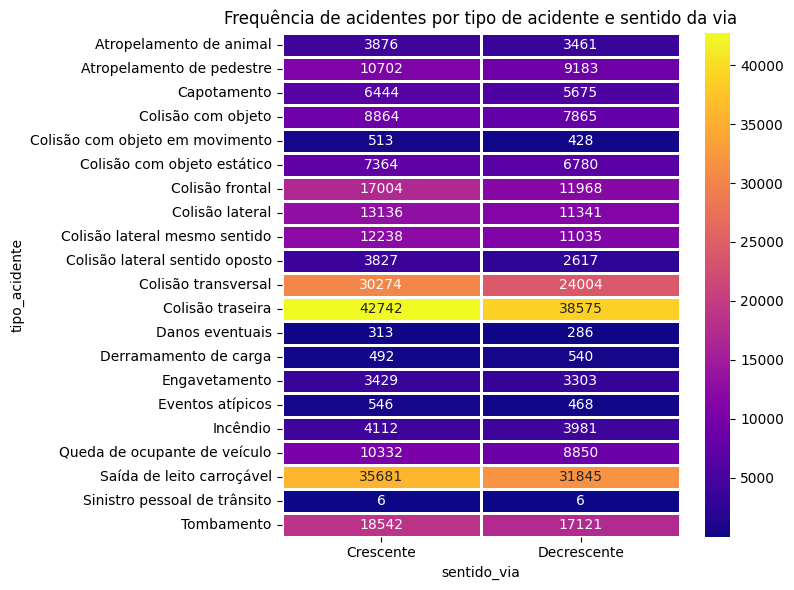

In [ ]:
df = df_accidents.copy()
df = df.groupby(['tipo_acidente', 'sentido_via']).size().unstack().fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por tipo de acidente e sentido da via")
plt.tight_layout()
plt.show()

#### tipo_acidente x causa_acidente (A-C)

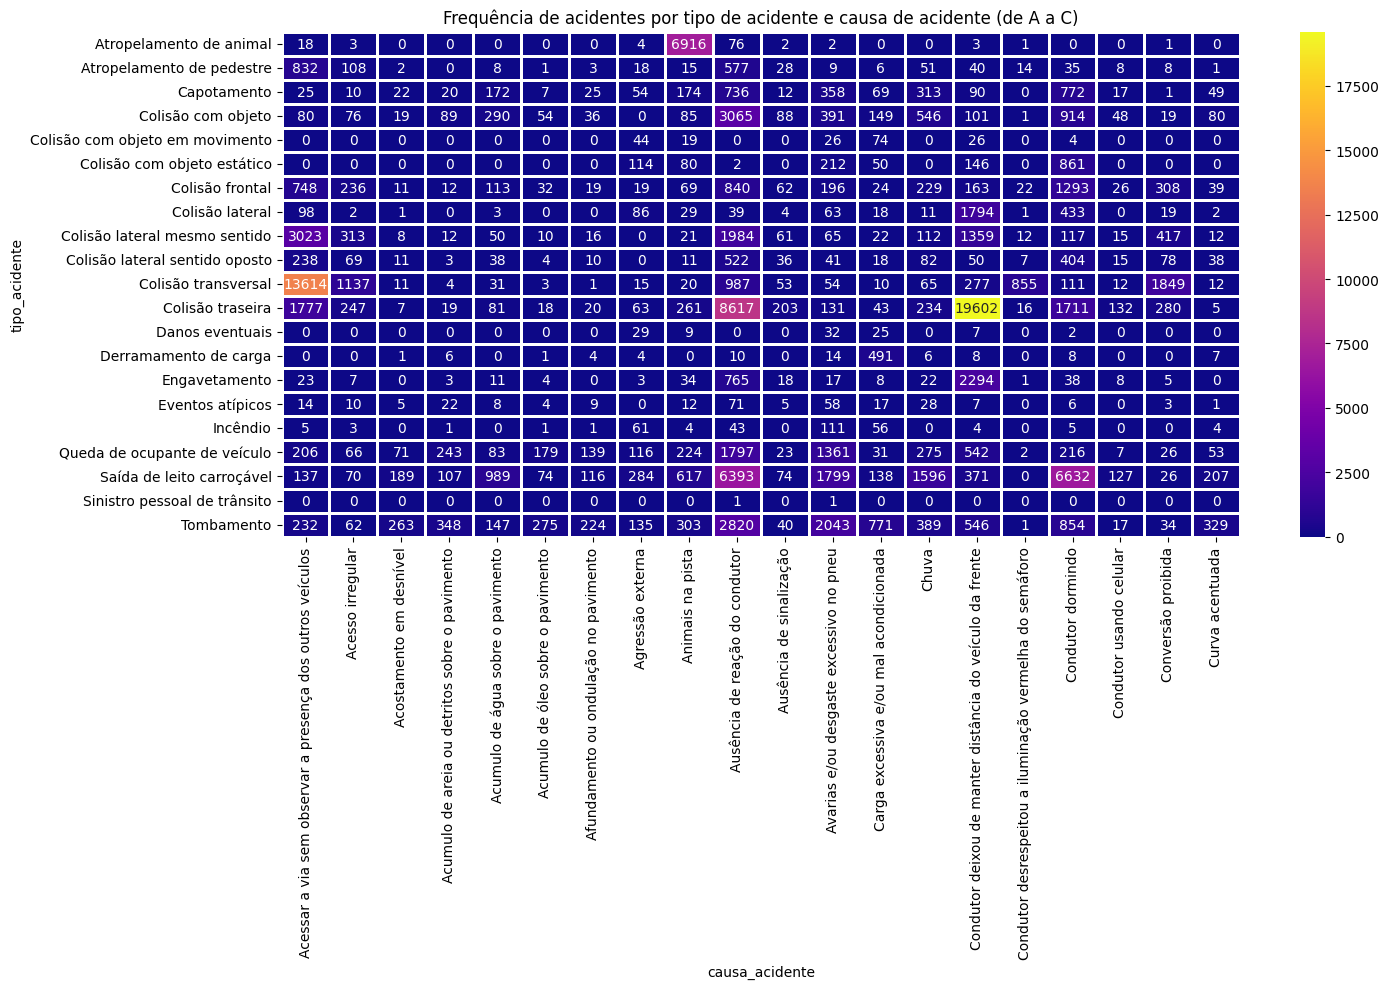

In [ ]:
starts_with = ("A", "B", "C")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['tipo_acidente', 'causa_acidente']).size().unstack().fillna(0)

plt.figure(figsize=(15, 10))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por tipo de acidente e causa de acidente (de A a C)")
plt.tight_layout()
plt.show()

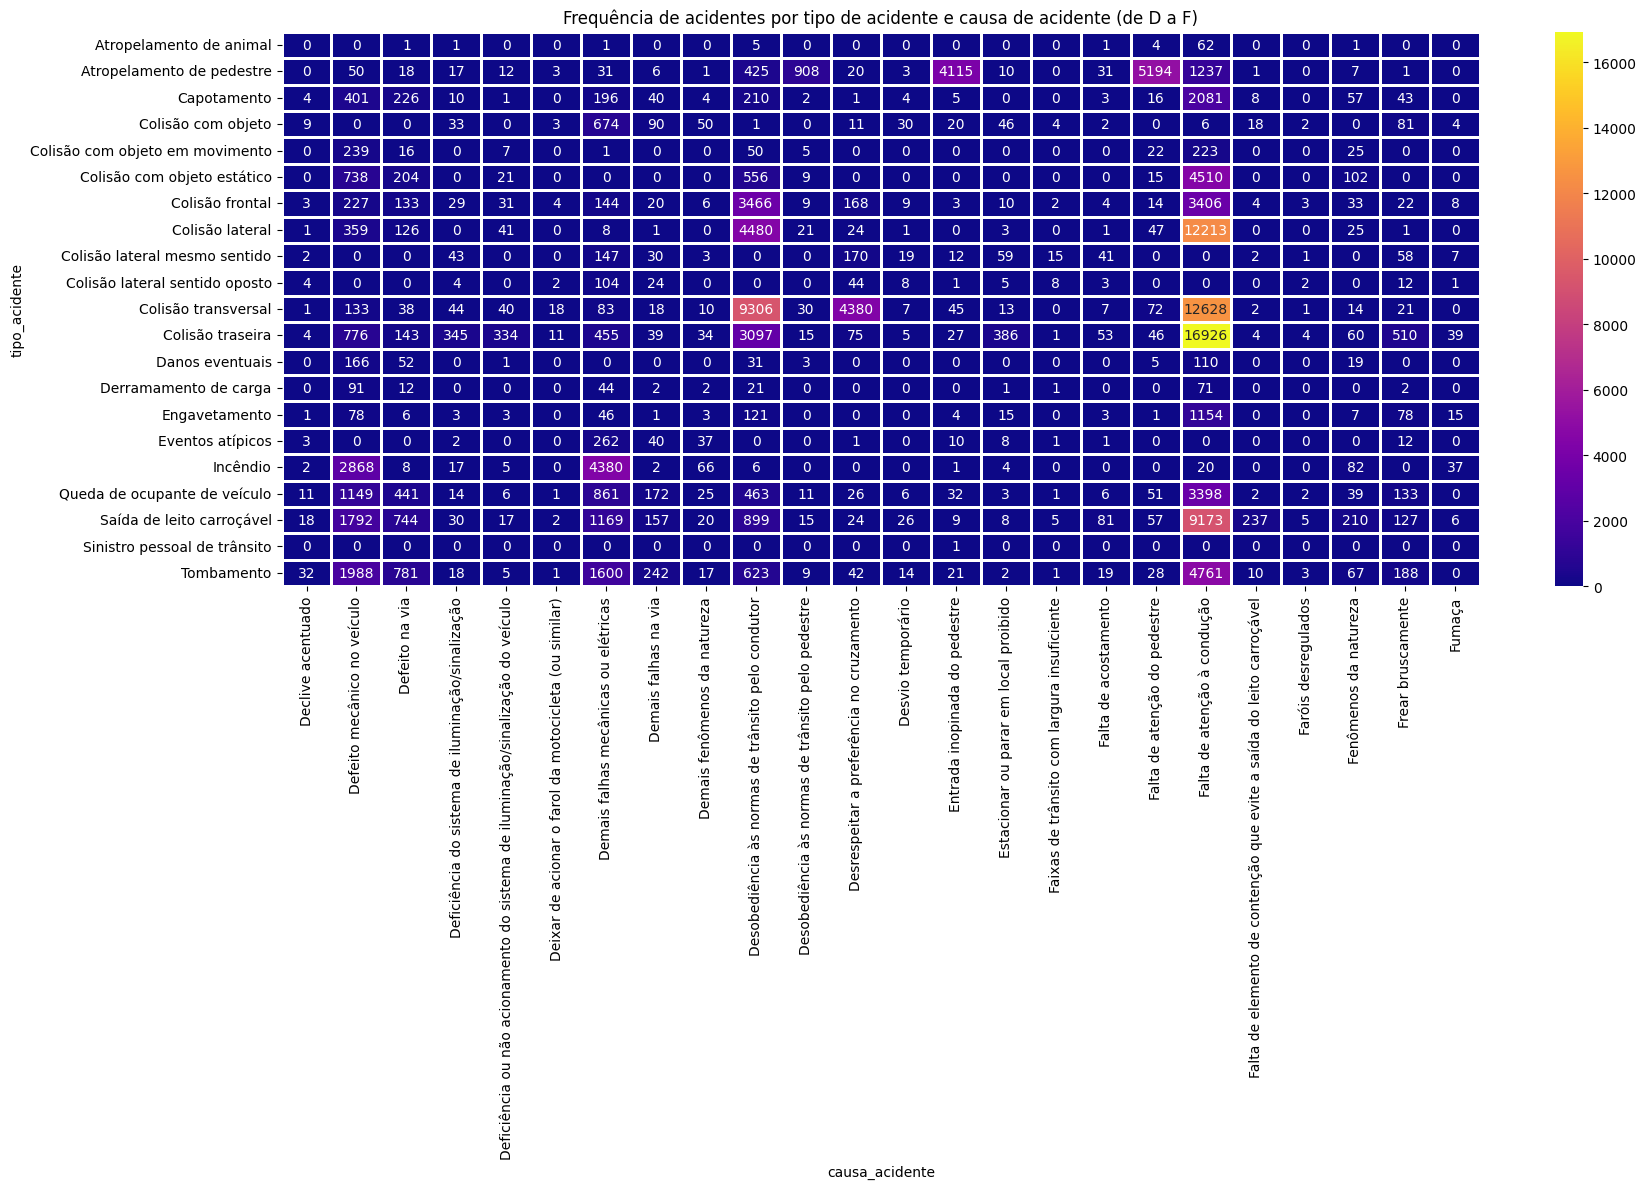

In [ ]:
starts_with = ("D", "E", "F")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['tipo_acidente', 'causa_acidente']).size().unstack().fillna(0)

plt.figure(figsize=(18, 12))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por tipo de acidente e causa de acidente (de D a F)")
plt.tight_layout()
plt.show()

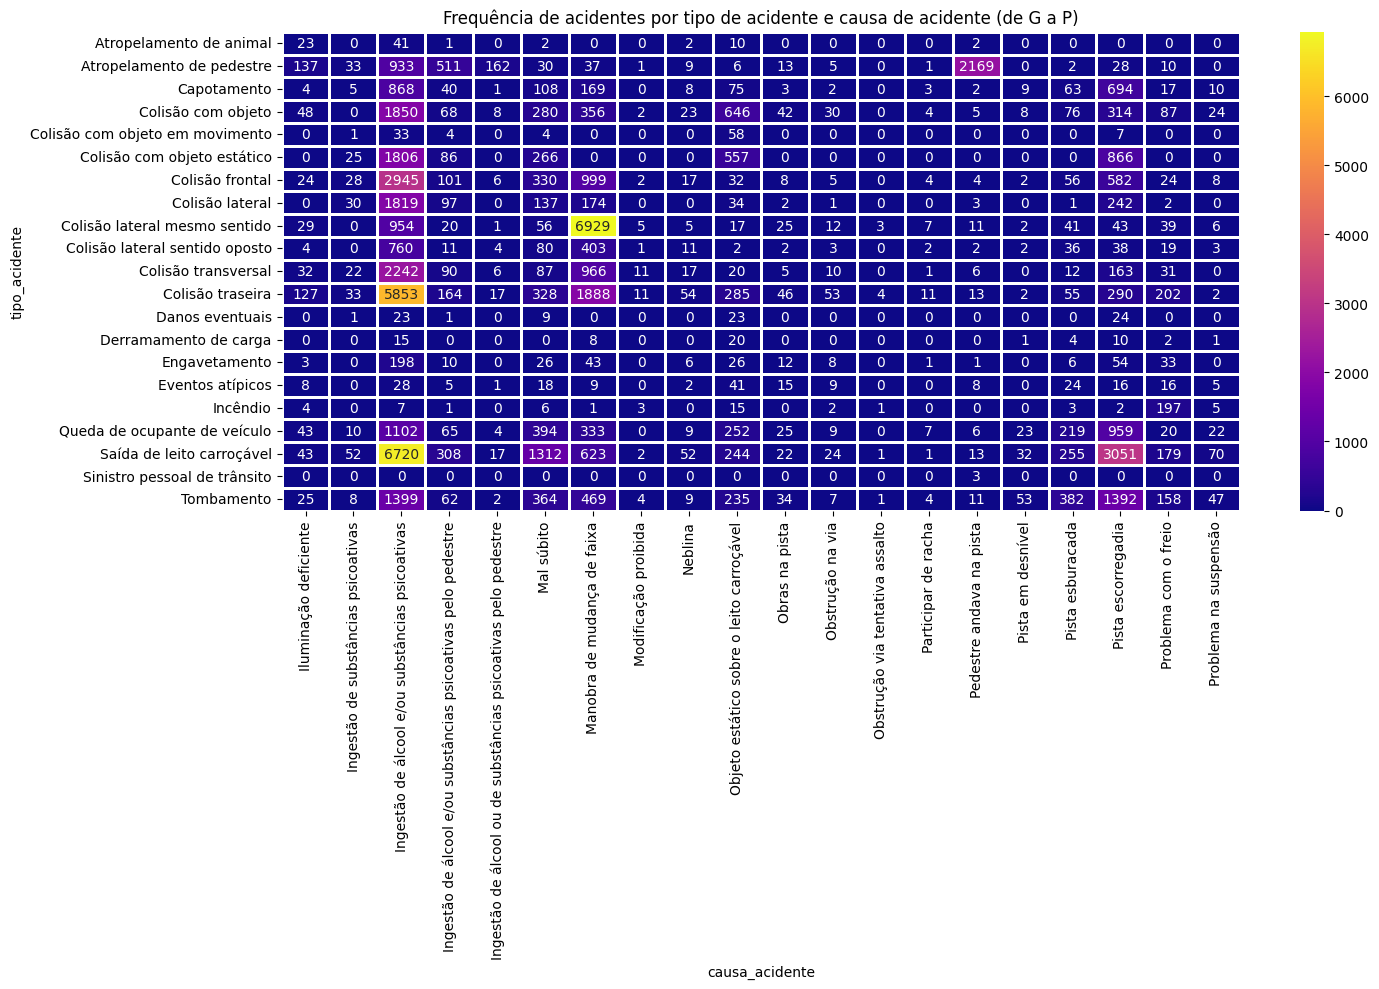

In [ ]:
starts_with = ("G", "H", "I", "J", "L", "M", "N", "O", "P")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['tipo_acidente', 'causa_acidente']).size().unstack().fillna(0)

plt.figure(figsize=(15, 10))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por tipo de acidente e causa de acidente (de G a P)")
plt.tight_layout()
plt.show()

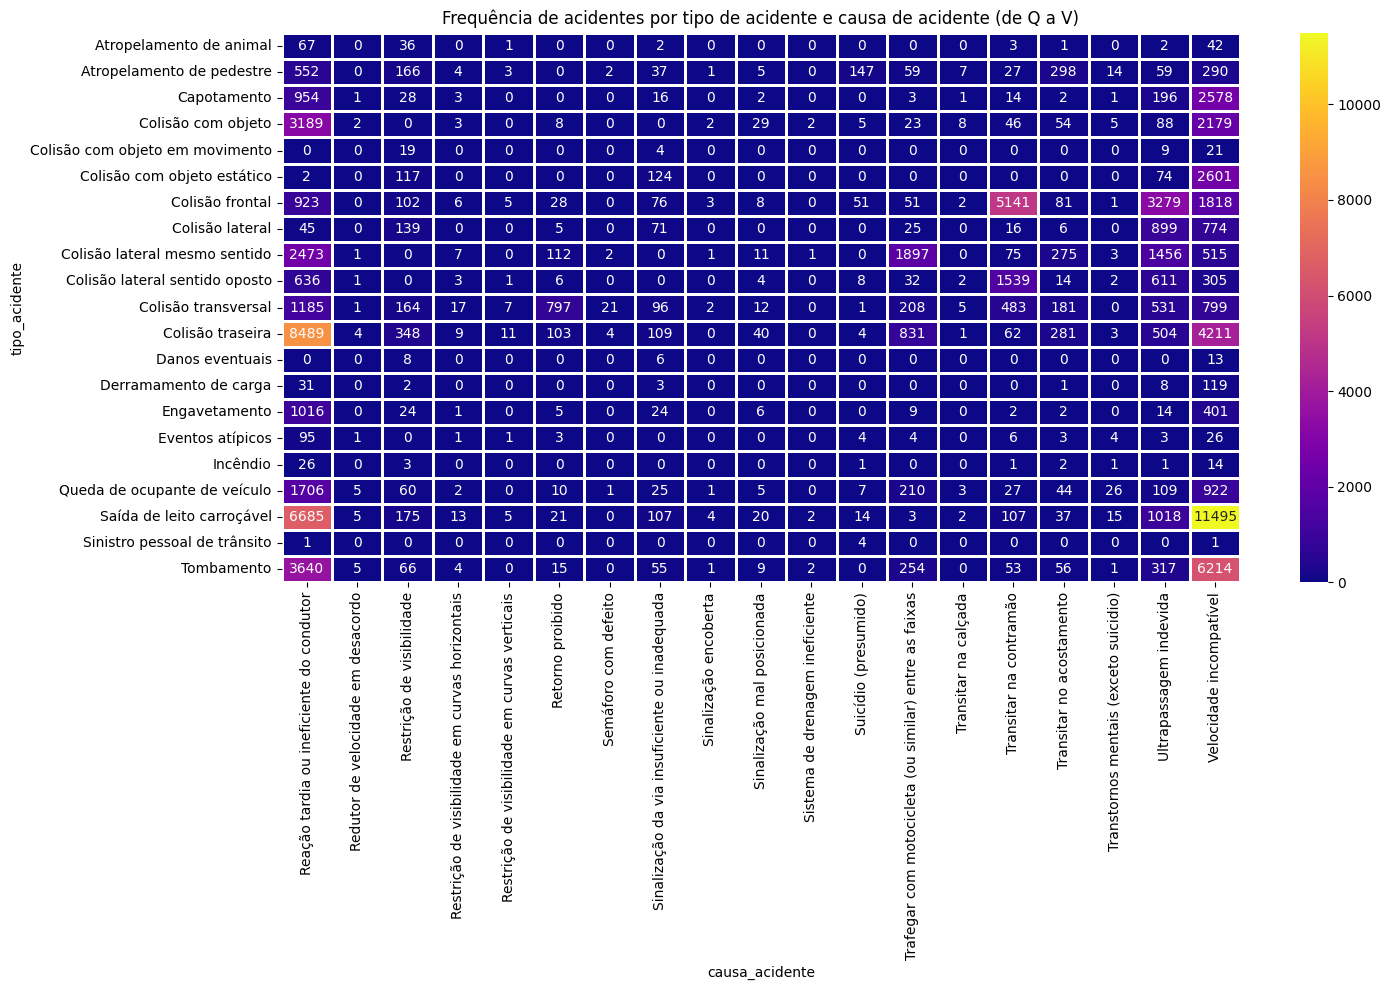

In [ ]:
starts_with = ("Q", "R", "S", "T", "U", "V")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['tipo_acidente', 'causa_acidente']).size().unstack().fillna(0)

plt.figure(figsize=(15, 10))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por tipo de acidente e causa de acidente (de Q a V)")
plt.tight_layout()
plt.show()

#### tipo_acidente x classificacao_acidente

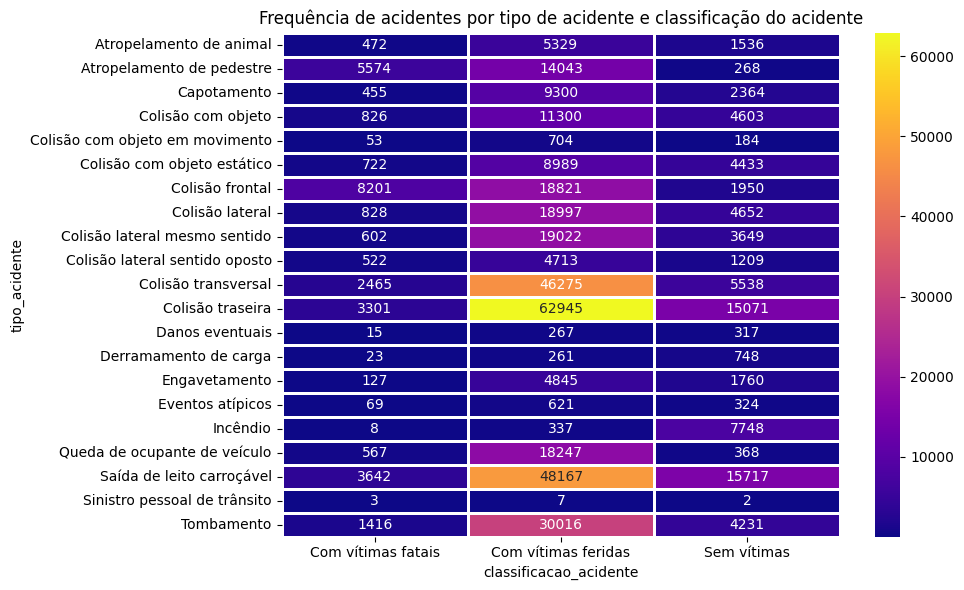

In [ ]:
df = df_accidents.copy()
df = df.groupby(['tipo_acidente', 'classificacao_acidente']).size().unstack().fillna(0)

plt.figure(figsize=(10, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por tipo de acidente e classificação do acidente")
plt.tight_layout()
plt.show()

#### tipo_acidente x pessoas (0-20)

In [ ]:
min, max = 0, 20

df = df_accidents.copy()
df = df.groupby(['tipo_acidente', 'pessoas']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(18, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por tipo de acidente e pessoas envolvidas (0 a 20)")
plt.tight_layout()
plt.show()

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

#### tipo_acidente x pessoas (mais de 20)

In [ ]:
min, max = 21, 100

df = df_accidents.copy()
df = df.groupby(['tipo_acidente', 'pessoas']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(18, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por tipo de acidente e pessoas envolvidas (mais de 20)")
plt.tight_layout()
plt.show()

#### tipo_acidente x veiculos

In [ ]:
df = df_accidents.copy()
df = df.groupby(['tipo_acidente', 'veiculos']).size().unstack().fillna(0)

plt.figure(figsize=(15, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por tipo de acidente e veículos envolvidos")
plt.tight_layout()
plt.show()

### Causa do acidente (A-C)

#### causa_acidente x tipo_data

In [ ]:
starts_with = ("A", "B", "C")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'tipo_data']).size().unstack().fillna(0)


plt.figure(figsize=(15, 8))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e tipo de data")
plt.tight_layout()
plt.show()

#### causa_acidente x mes_ano (ano)

In [ ]:
starts_with = ("A", "B", "C")

df = df_accidents.copy()
df["mes_ano"] = df["mes_ano"].dt.year
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'mes_ano']).size().unstack().fillna(0)


plt.figure(figsize=(15, 8))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente (de A a C) e ano")
plt.tight_layout()
plt.show()

#### causa_acidente x mes_ano (mes)

In [ ]:
starts_with = ("A", "B", "C")

df = df_accidents.copy()
df["mes_ano"] = df["mes_ano"].dt.month
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'mes_ano']).size().unstack().fillna(0)


plt.figure(figsize=(15, 8))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente (de A a C) e mês")
plt.tight_layout()
plt.show()

#### causa_acidente x dia_semana

In [ ]:
starts_with = ("A", "B", "C")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'dia_semana']).size().unstack().fillna(0)


plt.figure(figsize=(15, 8))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente (A-C) e dia da semana")
plt.tight_layout()
plt.show()

#### causa_acidente x horario

In [ ]:
starts_with = ("A", "B", "C")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df.loc[:, "horario"] = to_datetime(df["horario"]).astype(str).str.zfill(2)
df = df.groupby(['causa_acidente', 'horario']).size().unstack().fillna(0)

plt.figure(figsize=(20, 8))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente (A-C) e horário HH:00 - HH:59")
plt.tight_layout()
plt.show()

#### causa_acidente x fase_dia

In [ ]:
starts_with = ("A", "B", "C")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'fase_dia']).size().unstack().fillna(0)


plt.figure(figsize=(15, 8))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente (A-C) e fase do dia")
plt.tight_layout()
plt.show()

#### causa_acidente x condicao_metereologica

In [ ]:
starts_with = ("A", "B", "C")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'condicao_metereologica']).size().unstack().fillna(0)
df.columns.name = "condicao_meteorologica"

plt.figure(figsize=(18, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente (A-C) e condição meteorológica")
plt.tight_layout()
plt.show()

#### causa_acidente x uf

In [ ]:
starts_with = ("A", "B", "C")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'uf']).size().unstack().fillna(0)

plt.figure(figsize=(20, 8))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e estado")
plt.tight_layout()
plt.show()

#### causa_acidente x br (radiais)

In [ ]:
min, max = 10, 99
starts_with = ("A", "B", "C")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'br']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(12, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e rodovias radiais")
plt.tight_layout()
plt.show()

#### causa_acidente x br (longitudinais)

In [ ]:
min, max = 10, 99
starts_with = ("A", "B", "C")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'br']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(15, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e rodovias longitudinais")
plt.tight_layout()
plt.show()

#### causa_acidente x br (transversais)

In [ ]:
min, max = 200, 299
starts_with = ("A", "B", "C")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'br']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(15, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e rodovias transversais")
plt.tight_layout()
plt.show()

#### causa_acidente x br (diagonais)

In [ ]:
min, max = 300, 399
starts_with = ("A", "B", "C")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'br']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(20, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e rodovias diagonais")
plt.tight_layout()
plt.show()

#### causa_acidente x br (de ligação)

In [ ]:
min, max = 400, 499
starts_with = ("A", "B", "C")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'br']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(32, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e rodovias de ligação")
plt.tight_layout()
plt.show()

#### causa_acidente x uso_solo

In [ ]:
starts_with = ("A", "B", "C")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'uso_solo']).size().unstack().fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e uso do solo")
plt.tight_layout()
plt.show()

#### causa_acidente x tipo_pista

In [ ]:
starts_with = ("A", "B", "C")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'tipo_pista']).size().unstack().fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e tipo de pista")
plt.tight_layout()
plt.show()

#### causa_acidente x sentido_via

In [ ]:
starts_with = ("A", "B", "C")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'sentido_via']).size().unstack().fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e sentido da via")
plt.tight_layout()
plt.show()

#### causa_acidente x classificacao_acidente

In [ ]:
starts_with = ("A", "B", "C")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'classificacao_acidente']).size().unstack().fillna(0)

plt.figure(figsize=(10, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e classificação do acidente")
plt.tight_layout()
plt.show()

#### causa_acidente x pessoas (0-20)

In [ ]:
min, max = 0, 20
starts_with = ("A", "B", "C")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'pessoas']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(18, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e pessoas envolvidas (0 a 20)")
plt.tight_layout()
plt.show()

#### causa_acidente x pessoas (mais de 20)

In [ ]:
min, max = 21, 100
starts_with = ("A", "B", "C")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'pessoas']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(18, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e pessoas envolvidas (mais de 20)")
plt.tight_layout()
plt.show()

#### causa_acidente x veiculos

In [ ]:
starts_with = ("A", "B", "C")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'veiculos']).size().unstack().fillna(0)

plt.figure(figsize=(15, 8))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e veículos envolvidos")
plt.tight_layout()
plt.show()

### Causa do acidente (G-H)

#### causa_acidente x tipo_data

In [ ]:
starts_with = ("G", "H", "I", "J", "L", "M", "N", "O", "P")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'tipo_data']).size().unstack().fillna(0)


plt.figure(figsize=(15, 8))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente (G-P) e tipo de data")
plt.tight_layout()
plt.show()

#### causa_acidente x mes_ano (ano)

In [ ]:
starts_with = ("G", "H", "I", "J", "L", "M", "N", "O", "P")

df = df_accidents.copy()
df["mes_ano"] = df["mes_ano"].dt.year
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'mes_ano']).size().unstack().fillna(0)


plt.figure(figsize=(15, 8))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente (de G a P) e ano")
plt.tight_layout()
plt.show()

#### causa_acidente x mes_ano (mes)

In [ ]:
starts_with = ("G", "H", "I", "J", "L", "M", "N", "O", "P")

df = df_accidents.copy()
df["mes_ano"] = df["mes_ano"].dt.month
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'mes_ano']).size().unstack().fillna(0)


plt.figure(figsize=(15, 8))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente (de G a P) e mês")
plt.tight_layout()
plt.show()

#### causa_acidente x dia_semana

In [ ]:
starts_with = ("G", "H", "I", "J", "L", "M", "N", "O", "P")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'dia_semana']).size().unstack().fillna(0)


plt.figure(figsize=(15, 8))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente (G-P) e dia da semana")
plt.tight_layout()
plt.show()

#### causa_acidente x horario

In [ ]:
starts_with = ("G", "H", "I", "J", "L", "M", "N", "O", "P")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df.loc[:, "horario"] = to_datetime(df["horario"]).astype(str).str.zfill(2)
df = df.groupby(['causa_acidente', 'horario']).size().unstack().fillna(0)

plt.figure(figsize=(20, 8))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente (G-P) e horário HH:00 - HH:59")
plt.tight_layout()
plt.show()

#### causa_acidente x fase_dia

In [ ]:
starts_with = ("G", "H", "I", "J", "L", "M", "N", "O", "P")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'fase_dia']).size().unstack().fillna(0)


plt.figure(figsize=(15, 8))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente (G-P) e fase do dia")
plt.tight_layout()
plt.show()

#### causa_acidente x condicao_metereologica

In [ ]:
starts_with = ("G", "H", "I", "J", "L", "M", "N", "O", "P")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'condicao_metereologica']).size().unstack().fillna(0)
df.columns.name = "condicao_meteorologica"

plt.figure(figsize=(18, 8))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente (G-P) e condição meteorológica")
plt.tight_layout()
plt.show()

#### causa_acidente x uf

In [ ]:
starts_with = ("G", "H", "I", "J", "L", "M", "N", "O", "P")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'uf']).size().unstack().fillna(0)

plt.figure(figsize=(20, 8))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e estado")
plt.tight_layout()
plt.show()

#### causa_acidente x br (radiais)

In [ ]:
min, max = 10, 99
starts_with = ("G", "H", "I", "J", "L", "M", "N", "O", "P")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'br']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(12, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e rodovias radiais")
plt.tight_layout()
plt.show()

#### causa_acidente x br (longitudinais)

In [ ]:
min, max = 100, 199
starts_with = ("G", "H", "I", "J", "L", "M", "N", "O", "P")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'br']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(15, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e rodovias longitudinais")
plt.tight_layout()
plt.show()

#### causa_acidente x br (transversais)

In [ ]:
min, max = 200, 299
starts_with = ("G", "H", "I", "J", "L", "M", "N", "O", "P")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'br']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(15, 8))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e rodovias transversais")
plt.tight_layout()
plt.show()

#### causa_acidente x br (diagonais)

In [ ]:
min, max = 300, 399
starts_with = ("G", "H", "I", "J", "L", "M", "N", "O", "P")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'br']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(20, 8))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e rodovias diagonais")
plt.tight_layout()
plt.show()

#### causa_acidente x br (de ligação)

In [ ]:
min, max = 400, 499
starts_with = ("G", "H", "I", "J", "L", "M", "N", "O", "P")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'br']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(32, 8))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e rodovias de ligação")
plt.tight_layout()
plt.show()

#### causa_acidente x uso_solo

In [ ]:
starts_with = ("G", "H", "I", "J", "L", "M", "N", "O", "P")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'uso_solo']).size().unstack().fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e uso do solo")
plt.tight_layout()
plt.show()

#### causa_acidente x tipo_pista

In [ ]:
starts_with = ("G", "H", "I", "J", "L", "M", "N", "O", "P")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'tipo_pista']).size().unstack().fillna(0)

plt.figure(figsize=(10, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e tipo de pista")
plt.tight_layout()
plt.show()

#### causa_acidente x sentido_via

In [ ]:
starts_with = ("G", "H", "I", "J", "L", "M", "N", "O", "P")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'sentido_via']).size().unstack().fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e sentido da via")
plt.tight_layout()
plt.show()

#### causa_acidente x classificacao_acidente

In [ ]:
starts_with = ("G", "H", "I", "J", "L", "M", "N", "O", "P")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'classificacao_acidente']).size().unstack().fillna(0)

plt.figure(figsize=(10, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e classificação do acidente")
plt.tight_layout()
plt.show()

#### causa_acidente x pessoas (0-20)

In [ ]:
min, max = 0, 20
starts_with = ("G", "H", "I", "J", "L", "M", "N", "O", "P")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'pessoas']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(18, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e pessoas envolvidas (0 a 20)")
plt.tight_layout()
plt.show()

#### causa_acidente x pessoas (mais de 20)

In [ ]:
min, max = 21, 100
starts_with = ("G", "H", "I", "J", "L", "M", "N", "O", "P")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'pessoas']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(18, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e pessoas envolvidas (mais de 20)")
plt.tight_layout()
plt.show()

#### causa_acidente x veiculos

In [ ]:
starts_with = ("G", "H", "I", "J", "L", "M", "N", "O", "P")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'veiculos']).size().unstack().fillna(0)

plt.figure(figsize=(15, 8))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e veículos envolvidos")
plt.tight_layout()
plt.show()

### Causa do acidente (Q-V)

#### causa_acidente x tipo_data

In [ ]:
starts_with = ("Q", "R", "S", "T", "U", "V")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'tipo_data']).size().unstack().fillna(0)


plt.figure(figsize=(15, 8))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e tipo de data")
plt.tight_layout()
plt.show()

#### causa_acidente x mes_ano (ano)

In [ ]:
starts_with = ("Q", "R", "S", "T", "U", "V")

df = df_accidents.copy()
df["mes_ano"] = df["mes_ano"].dt.year
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'mes_ano']).size().unstack().fillna(0)


plt.figure(figsize=(15, 8))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente (de Q a V) e ano")
plt.tight_layout()
plt.show()

#### causa_acidente x mes_ano (mes)

In [ ]:
starts_with = ("Q", "R", "S", "T", "U", "V")

df = df_accidents.copy()
df["mes_ano"] = df["mes_ano"].dt.month
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'mes_ano']).size().unstack().fillna(0)


plt.figure(figsize=(15, 8))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente (de Q a V) e mês")
plt.tight_layout()
plt.show()

#### causa_acidente x dia_semana

In [ ]:
starts_with = ("Q", "R", "S", "T", "U", "V")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'dia_semana']).size().unstack().fillna(0)


plt.figure(figsize=(15, 8))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente (Q-V) e dia da semana")
plt.tight_layout()
plt.show()

#### causa_acidente x horario

In [ ]:
starts_with = ("Q", "R", "S", "T", "U", "V")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df.loc[:, "horario"] = to_datetime(df["horario"]).astype(str).str.zfill(2)
df = df.groupby(['causa_acidente', 'horario']).size().unstack().fillna(0)

plt.figure(figsize=(20, 8))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente (Q-V) e horário HH:00 - HH:59")
plt.tight_layout()
plt.show()

#### causa_acidente x fase_dia

In [ ]:
starts_with = ("Q", "R", "S", "T", "U", "V")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'fase_dia']).size().unstack().fillna(0)


plt.figure(figsize=(15, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente (Q-V) e fase do dia")
plt.tight_layout()
plt.show()

#### causa_acidente x condicao_metereologica

In [ ]:
starts_with = ("Q", "R", "S", "T", "U", "V")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'condicao_metereologica']).size().unstack().fillna(0)
df.columns.name = "condicao_meteorologica"

plt.figure(figsize=(18, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente (Q-V) e condição meteorológica")
plt.tight_layout()
plt.show()

#### causa_acidente x uf

In [ ]:
starts_with = ("Q", "R", "S", "T", "U", "V")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'uf']).size().unstack().fillna(0)

plt.figure(figsize=(20, 8))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e estado")
plt.tight_layout()
plt.show()

#### causa_acidente x br (radiais)

In [ ]:
min, max = 10, 99
starts_with = ("Q", "R", "S", "T", "U", "V")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'br']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(12, 8))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e rodovias de radiais")
plt.tight_layout()
plt.show()

#### causa_acidente x br (longitudinais)

In [ ]:
min, max = 100, 199
starts_with = ("Q", "R", "S", "T", "U", "V")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'br']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(15, 8))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e rodovias de longitudinais")
plt.tight_layout()
plt.show()

#### causa_acidente x br (transversais)

In [ ]:
starts_with = ("Q", "R", "S", "T", "U", "V")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'br']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(15, 8))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e rodovias de transversais")
plt.tight_layout()
plt.show()

#### causa_acidente x br (diagonais)

In [ ]:
min, max = 200, 299
starts_with = ("Q", "R", "S", "T", "U", "V")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'br']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(20, 8))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e rodovias de diagonais")
plt.tight_layout()
plt.show()

#### causa_acidente x br (de ligação)

In [ ]:
min, max = 300, 399
starts_with = ("Q", "R", "S", "T", "U", "V")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'br']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(32, 8))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e rodovias de ligação")
plt.tight_layout()
plt.show()

#### causa_acidente x uso_solo

In [ ]:
starts_with = ("Q", "R", "S", "T", "U", "V")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'uso_solo']).size().unstack().fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e uso do solo")
plt.tight_layout()
plt.show()

#### causa_acidente x tipo_pista

In [ ]:
starts_with = ("Q", "R", "S", "T", "U", "V")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'tipo_pista']).size().unstack().fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e tipo de pista")
plt.tight_layout()
plt.show()

#### causa_acidente x sentido_via

In [ ]:
starts_with = ("Q", "R", "S", "T", "U", "V")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'sentido_via']).size().unstack().fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e sentido da via")
plt.tight_layout()
plt.show()

#### causa_acidente x classificacao_acidente

In [ ]:
starts_with = ("Q", "R", "S", "T", "U", "V")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'classificacao_acidente']).size().unstack().fillna(0)

plt.figure(figsize=(10, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e classificação do acidente")
plt.tight_layout()
plt.show()

#### causa_acidente x pessoas (0-20)

In [ ]:
min, max = 0, 20
starts_with = ("Q", "R", "S", "T", "U", "V")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'pessoas']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(18, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e pessoas envolvidas (0 a 20)")
plt.tight_layout()
plt.show()

#### causa_acidente x pessoas (mais de 20)

In [ ]:
min, max = 21, 100
starts_with = ("Q", "R", "S", "T", "U", "V")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'pessoas']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(18, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e pessoas envolvidas (mais de 20)")
plt.tight_layout()
plt.show()

#### causa_acidente x veiculos

In [ ]:
starts_with = ("Q", "R", "S", "T", "U", "V")

df = df_accidents.copy()
df = df[df["causa_acidente"].str.startswith(starts_with, na=False)]
df = df.groupby(['causa_acidente', 'veiculos']).size().unstack().fillna(0)

plt.figure(figsize=(15, 6))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por causa de acidente e veículos envolvidos")
plt.tight_layout()
plt.show()

### Classificação do acidente

#### classificacao_acidente x tipo_data

In [ ]:
df = df_accidents.copy()
df = df.groupby(['classificacao_acidente', 'tipo_data']).size().unstack().fillna(0)


plt.figure(figsize=(12, 5))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por classificação de acidente e tipo de data")
plt.tight_layout()
plt.show()

#### classificacao_acidente x mes_ano (ano)

In [ ]:
df = df_accidents.copy()
df["mes_ano"] = df["mes_ano"].dt.year
df = df.groupby(['classificacao_acidente', 'mes_ano']).size().unstack().fillna(0)
df.columns.name = "ano"

plt.figure(figsize=(8, 3))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por classificação de acidente e ano")
plt.tight_layout()
plt.show()

#### classificacao_acidente x mes_ano (mes)

In [ ]:
df = df_accidents.copy()
df["mes_ano"] = df["mes_ano"].dt.month
df = df.groupby(['classificacao_acidente', 'mes_ano']).size().unstack().fillna(0)
df.columns.name = "mes"

plt.figure(figsize=(10, 3))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por classificação de acidente e mês")
plt.tight_layout()
plt.show()

#### classificacao_acidente x dia_semana

In [ ]:
df = df_accidents.copy()
df = df.groupby(['classificacao_acidente', 'dia_semana']).size().unstack().fillna(0)
df = df[get_weekdays()]

plt.figure(figsize=(10, 3))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por tipo de classificação e dia da semana")
plt.tight_layout()
plt.show()

#### classificacao_acidente x horario

In [ ]:
df = df_accidents.copy()
df.loc[:, "horario"] = to_datetime(df["horario"]).astype(str).str.zfill(2)
df = df.groupby(['classificacao_acidente', 'horario']).size().unstack().fillna(0)

plt.figure(figsize=(18, 4))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por classificação de acidente e horário HH:00 - HH:59")
plt.tight_layout()
plt.show()

#### classificacao_acidente x fase_dia

In [ ]:
df = df_accidents.copy()
df = df.groupby(['classificacao_acidente', 'fase_dia']).size().unstack().fillna(0)


plt.figure(figsize=(12, 4))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por classificação de acidente e fase do dia")
plt.tight_layout()
plt.show()

#### classificacao_acidente x condicao_metereologica

In [ ]:
df = df_accidents.copy()
df = df.groupby(['classificacao_acidente', 'condicao_metereologica']).size().unstack().fillna(0)
df.columns.name = "condicao_meteorologica"

plt.figure(figsize=(18, 5))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por classificação de acidente e condição meteorológica")
plt.tight_layout()
plt.show()

#### classificacao_acidente x uf

In [ ]:
df = df_accidents.copy()
df = df.groupby(['classificacao_acidente', 'uf']).size().unstack().fillna(0)

plt.figure(figsize=(20, 4))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por classificação de acidente e estado")
plt.tight_layout()
plt.show()

#### classificacao_acidente x br (radiais)

In [ ]:
min, max = 10, 99

df = df_accidents.copy()
df = df.groupby(['classificacao_acidente', 'br']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(10, 4))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por classificação de acidente e rodovias radiais")
plt.tight_layout()
plt.show()

#### tipo_acidente x br (longitudinais)

In [ ]:
min, max = 100, 199

df = df_accidents.copy()
df = df.groupby(['classificacao_acidente', 'br']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(12, 3))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por classificação de acidente e rodovias longitudinais")
plt.tight_layout()
plt.show()

#### tipo_acidente x br (transversais)

In [ ]:
min, max = 200, 299

df = df_accidents.copy()
df = df.groupby(['classificacao_acidente', 'br']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(15, 3))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por classificação de acidente e rodovias transversais")
plt.tight_layout()
plt.show()

#### tipo_acidente x br (diagonais)

In [ ]:
min, max = 300, 399

df = df_accidents.copy()
df = df.groupby(['classificacao_acidente', 'br']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(20, 3))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por classificação de acidente e rodovias diagonais")
plt.tight_layout()
plt.show()

#### tipo_acidente x br (de ligação)

In [ ]:
min, max = 400, 499

df = df_accidents.copy()
df = df.groupby(['classificacao_acidente', 'br']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(32, 4))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por classificação de acidente e rodovias de ligação")
plt.tight_layout()
plt.show()

#### classificacao_acidente x uso_solo

In [ ]:
df = df_accidents.copy()
df = df.groupby(['classificacao_acidente', 'uso_solo']).size().unstack().fillna(0)

plt.figure(figsize=(8, 4))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por classificação de acidente e uso do solo")
plt.tight_layout()
plt.show()

#### classificacao_acidente x tipo_pista

In [ ]:
df = df_accidents.copy()
df = df.groupby(['classificacao_acidente', 'tipo_pista']).size().unstack().fillna(0)

plt.figure(figsize=(8, 4))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por classificação de acidente e tipo de pista")
plt.tight_layout()
plt.show()

#### classificacao_acidente x sentido_via

In [ ]:
df = df_accidents.copy()
df = df.groupby(['classificacao_acidente', 'sentido_via']).size().unstack().fillna(0)

plt.figure(figsize=(8, 4))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por classificação de acidente e sentido da via")
plt.tight_layout()
plt.show()

#### classificacao_acidente x pessoas (0-20)

In [ ]:
min, max = 0, 20

df = df_accidents.copy()
df = df.groupby(['classificacao_acidente', 'pessoas']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(15, 4))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por classificação de acidente e pessoas envolvidas (0 a 20)")
plt.tight_layout()
plt.show()

#### classificacao_acidente x pessoas (mais de 20)

In [ ]:
min, max = 21, 100

df = df_accidents.copy()
df = df.groupby(['classificacao_acidente', 'pessoas']).size().unstack().fillna(0)
df = df[[value for value in df.columns if isinstance(
    value, (int, float)) and min <= value <= max]]

plt.figure(figsize=(18, 4))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por classificação de acidente e pessoas envolvidas (mais de 20)")
plt.tight_layout()
plt.show()

#### classificacao_acidente x veiculos

In [ ]:
df = df_accidents.copy()
df = df.groupby(['classificacao_acidente', 'veiculos']).size().unstack().fillna(0)

plt.figure(figsize=(15, 4))
sns.heatmap(df, cmap="plasma", annot=True, fmt=".0f", lw=1,)
plt.title("Frequência de acidentes por classificação de acidente e veículos envolvidos")
plt.tight_layout()
plt.show()

## Análise multivariada

### Cramers V para identificar a correlação entre as categorias

In [ ]:
df_correlation = df_accidents.copy()
df_correlation.drop(columns=["data_inversa"], inplace=True)
df_correlation.set_index("id", inplace=True)


def apply_cramers_v(crosstab):
    chi2, _, _, _ = chi2_contingency(crosstab)
    n = crosstab.sum().sum()
    r, k = crosstab.shape
    phi2 = chi2 / n
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))


cols = df_correlation.columns
n = len(cols)

df_results = pd.DataFrame(index=cols, columns=cols, dtype=float)

for i in range(n):
    for j in range(i, n):
        col_x = cols[i]
        col_y = cols[j]
        result = apply_cramers_v(pd.crosstab(
            df_correlation[col_x], df_correlation[col_y]))
        df_results.loc[col_x, col_y] = result
        df_results.loc[col_y, col_x] = result

plt.figure(figsize=(12, 12))
sns.heatmap(
    df_results,
    mask=np.triu(np.ones_like(df_results, dtype=bool)),
    fmt=".2f",
    annot=True,
    cmap="plasma"
)
plt.title("Matriz de Cramérs V")
plt.show()

### PCA

#### Transformando cada categoria em uma coluna binária

In [ ]:
df_pca = df_accidents.copy()
df_pca.set_index("id", inplace=True)
columns_to_remove = [
    "data_inversa",
    "mes_ano",
    "horario",
    "km",
    "br",
    "pessoas",
    "veiculos"
]
df_pca.drop(columns=columns_to_remove, inplace=True)
df_pca = df_pca.reset_index()


encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_sparse = encoder.fit_transform(df_pca.select_dtypes(include='object'))
X_sparse

#### Padronizando as features

In [ ]:
svd = TruncatedSVD(n_components=35)  # escolha quantos componentes quer
X_reduzido = svd.fit_transform(X_sparse)
X_reduzido

In [ ]:
principalDf = pd.DataFrame(
    data=X_reduzido,
    columns=[f'PC{n}' for n in range(1, 36)]
)
principalDf.head()

In [ ]:
svd.explained_variance_ratio_

In [ ]:
sum(svd.explained_variance_ratio_[0:36])*100

In [ ]:
plt.figure(figsize=(20, 25))
sns.heatmap(
    principalDf.corr(),
    cmap="plasma",
    mask=np.triu(np.ones_like(principalDf.corr(), dtype=bool)),
)
plt.title("Correlação dos componentes principais", fontsize=20)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)